# Initial Setup and Data Loading
Step 1: Library Setup and Data Loading -
We begin by importing all necessary libraries for data manipulation, visualization, preprocessing, modeling, and evaluation. The dataset is loaded from Google Drive.


In [ ]:
# Importing Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing and modeling
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.impute import KNNImputer

# Evaluation metrics
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                            f1_score, roc_auc_score, confusion_matrix,
                            precision_recall_curve, roc_curve)

# Statistical modeling
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Dashboard interactivity
import ipywidgets as widgets
from IPython.display import display, clear_output
import random

In [ ]:
#mounting drive to access the file
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/My Drive/Leads 2.csv')
# Displaying basic information about the dataset
print(df.info())
print(df.head())
print(df.columns.tolist())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 37 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Prospect ID                                    9240 non-null   object 
 1   Lead Number                                    9240 non-null   int64  
 2   Lead Origin                                    9240 non-null   object 
 3   Lead Source                                    9204 non-null   object 
 4   Do Not Email                                   9240 non-null   object 
 5   Do Not Call                                    9240 non-null   object 
 6   Converted                                      9240 non-null   int64  
 7   TotalVisits                                    9103 non-null   float64
 8   Total Time Spent on Website                    9240 non-null   int64  
 9   Page Views Per Visit                           9103 

In [ ]:
# numerical and categorical columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = df.select_dtypes(include=['object']).columns
print("\nNumerical columns:")
print(numerical_cols.tolist())
print("\nCategorical columns:")
print(categorical_cols.tolist())


Numerical columns:
['Lead Number', 'Converted', 'TotalVisits', 'Total Time Spent on Website', 'Page Views Per Visit', 'Asymmetrique Activity Score', 'Asymmetrique Profile Score']

Categorical columns:
['Prospect ID', 'Lead Origin', 'Lead Source', 'Do Not Email', 'Do Not Call', 'Last Activity', 'Country', 'Specialization', 'How did you hear about X Education', 'What is your current occupation', 'What matters most to you in choosing a course', 'Search', 'Magazine', 'Newspaper Article', 'X Education Forums', 'Newspaper', 'Digital Advertisement', 'Through Recommendations', 'Receive More Updates About Our Courses', 'Tags', 'Lead Quality', 'Update me on Supply Chain Content', 'Get updates on DM Content', 'Lead Profile', 'City', 'Asymmetrique Activity Index', 'Asymmetrique Profile Index', 'I agree to pay the amount through cheque', 'A free copy of Mastering The Interview', 'Last Notable Activity']


# Initial Exploration and Handling Missing Values


In [ ]:
#retaining Columns with >50% Missing Values
# Columns: Lead Quality (51.59% missing), and the Asymmetrique group (Activity/Profile Index/Score, ~45.65% missing) and flag missing values
# For categorical columns:
df['Lead Quality'] = df['Lead Quality'].fillna('Unknown')
# For numerical columns:
df['Asymmetrique Activity Score'] = df['Asymmetrique Activity Score'].fillna(-1)
#Columns with 15-50% Missing Values
#Columns: Tags (36.29%), Country (26.63%), How did you hear about X Education (23.89%), What is your current occupation (29.11%), What matters most to you in choosing a course (29.32%), Lead Profile (29.32%)
cols_to_impute = ['Country', 'How did you hear about X Education',
                  'What is your current occupation',
                  'What matters most to you in choosing a course',
                  'Lead Profile', 'Tags']
for col in cols_to_impute:
    df[col] = df[col].fillna('Unknown')
# Handling 'Lead Source', 'Specialisation', 'Last Activity' column - Mode
df['Lead Source'] = df['Lead Source'].fillna(df['Lead Source'].mode()[0])
df['Specialization'] = df['Specialization'].fillna(df['Specialization'].mode()[0])
df['Last Activity'] = df['Last Activity'].fillna(df['Last Activity'].mode()[0])
# Handling 'City' column - Unknown
df['City'] = df['City'].fillna('Unknown')
# Handling 'TotalVisits' column - Median
# Handling 'Pages Views Per Visit' - Median
df['TotalVisits'] = df['TotalVisits'].fillna(df['TotalVisits'].median())
df['Page Views Per Visit'] = df['Page Views Per Visit'].fillna(df['Page Views Per Visit'].median())
print("TotalVisits and Page Views Per Visit missing values replaced with median.")

# Handling 'Last Activity' column - Mode
print("Missing values in Last Activity before imputation:", df['Last Activity'].isnull().sum())
df['Last Activity'] = df['Last Activity'].fillna(df['Last Activity'].mode()[0])
print("Missing values in Last Activity after imputation:", df['Last Activity'].isnull().sum())

# Handling 'City' column - Unknown
print("Missing values in City before imputation:", df['City'].isnull().sum())
df['City'] = df['City'].fillna('Unknown')
print("Missing values in City after imputation:", df['City'].isnull().sum())

# Handling Asymmetrique indices - unknown
for col in ['Asymmetrique Activity Index', 'Asymmetrique Profile Index']:
    print(f"Missing values in {col} before imputation:", df[col].isnull().sum())
    df[col] = df[col].fillna('Unknown')
    print(f"Missing values in {col} after imputation:", df[col].isnull().sum())


TotalVisits and Page Views Per Visit missing values replaced with median.
Missing values in Last Activity before imputation: 0
Missing values in Last Activity after imputation: 0
Missing values in City before imputation: 0
Missing values in City after imputation: 0
Missing values in Asymmetrique Activity Index before imputation: 4218
Missing values in Asymmetrique Activity Index after imputation: 0
Missing values in Asymmetrique Profile Index before imputation: 4218
Missing values in Asymmetrique Profile Index after imputation: 0


Missing Value Imputation
Used a combination of strategies:
- Fill categorical with "Unknown"
- Fill numerical with median or -1
- Use KNN Imputer for important score features with high missingness


Imputed Asymmetrique Score columns using KNN-imputation.
                              count  mean  std   min   25%   50%   75%   max  \
Asymmetrique Activity Score 9240.00  7.32 7.69 -1.00 -1.00 13.00 14.00 18.00   
Asymmetrique Profile Score  9240.00 16.10 1.36 11.00 15.80 15.80 16.00 20.00   

                             median  variance  skewness  kurtosis  
Asymmetrique Activity Score   13.00     59.18     -0.12     -1.92  
Asymmetrique Profile Score    15.80      1.86      0.81      1.44  


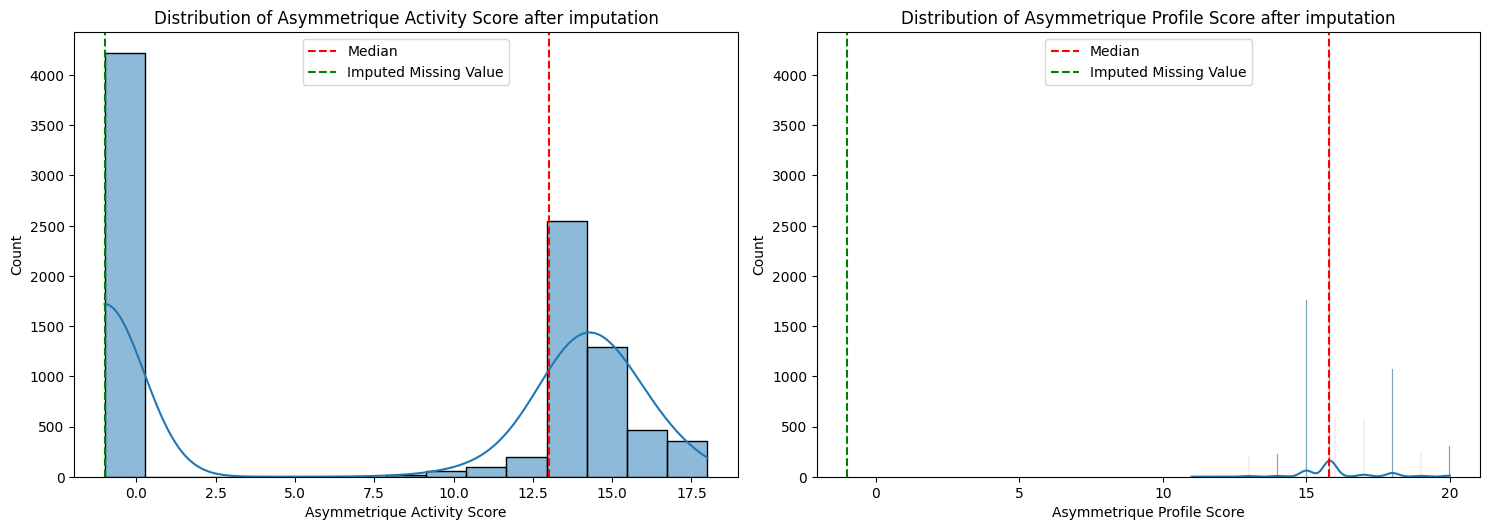

In [ ]:
# Defining columns to impute - trying a new library
# estimates missing values by finding the "k" nearest neighbors to a data point with a missing value and then imputing the missing value using the mean or median of those neighbors' values.
high_missing_cols = ['Asymmetrique Activity Score', 'Asymmetrique Profile Score']
knn_imputer = KNNImputer(n_neighbors=5)
df[high_missing_cols] = knn_imputer.fit_transform(df[high_missing_cols])
print("Imputed Asymmetrique Score columns using KNN-imputation.")

import matplotlib.pyplot as plt
import seaborn as sns

# Generating descriptive statistics for relevant numerical columns
numerical_cols = [

    'Asymmetrique Activity Score',
    'Asymmetrique Profile Score',

]
# descriptive statistics for these features
numerical_stats = df[numerical_cols].describe().T
# additional statistics
numerical_stats['median'] = df[numerical_cols].median()
numerical_stats['variance'] = df[numerical_cols].var()
numerical_stats['skewness'] = df[numerical_cols].skew()
numerical_stats['kurtosis'] = df[numerical_cols].kurtosis()

pd.set_option('display.float_format', '{:.2f}'.format)
print(numerical_stats)

# Plotting histograms for numerical columns
plt.figure(figsize=(15, 10))
for i, col in enumerate([ 'Asymmetrique Activity Score', 'Asymmetrique Profile Score']):
    plt.subplot(2, 2, i+1)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col} after imputation')
    plt.axvline(df[col].median(), color='red', linestyle='--', label='Median')
    if col in ['Asymmetrique Activity Score', 'Asymmetrique Profile Score']:
        plt.axvline(-1, color='green', linestyle='--', label='Imputed Missing Value')
    plt.legend()
plt.tight_layout()
plt.show()


# Data Quality Report

In [ ]:
# Function to generate a data quality report for all columns
def data_quality_report(df):
    report = []
    for col in df.columns:
        total_count = len(df[col])  # Total number of entries
        missing_count = df[col].isnull().sum()  # Count of missing values
        missing_proportion = missing_count / total_count  # Proportion of missing values
        report.append({
            "Column": col,
            "Total Count": total_count,
            "Missing Count": missing_count,
            "Proportion Missing": f"{missing_proportion:.2%}"
        })
    # Converting the report to a DataFrame for easier visualization
    report_df = pd.DataFrame(report)
    return report_df

# Generating and displaying the data quality report
data_quality_df = data_quality_report(df)
print(data_quality_df)

                                           Column  Total Count  Missing Count  \
0                                     Prospect ID         9240              0   
1                                     Lead Number         9240              0   
2                                     Lead Origin         9240              0   
3                                     Lead Source         9240              0   
4                                    Do Not Email         9240              0   
5                                     Do Not Call         9240              0   
6                                       Converted         9240              0   
7                                     TotalVisits         9240              0   
8                     Total Time Spent on Website         9240              0   
9                            Page Views Per Visit         9240              0   
10                                  Last Activity         9240              0   
11                          

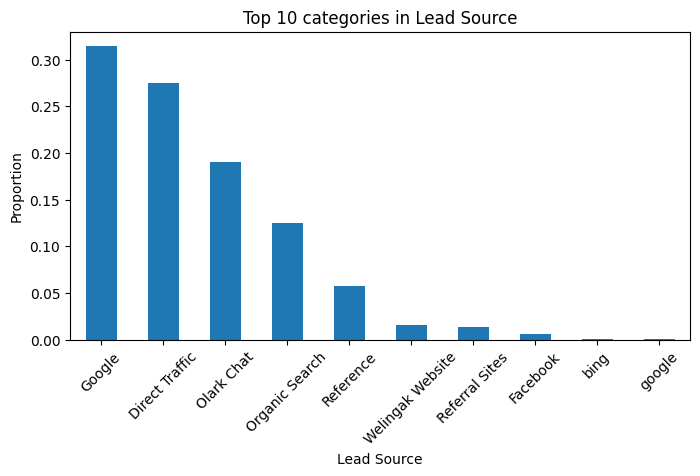

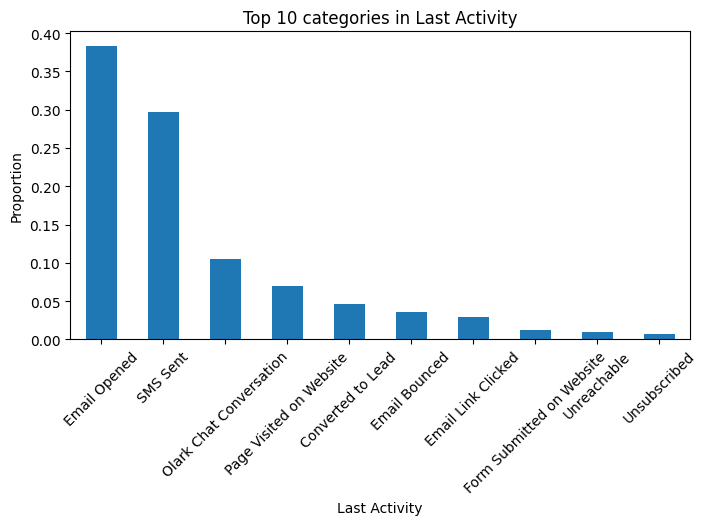

In [ ]:

def plot_top_categories(df, col, top_n=10):
    plt.figure(figsize=(8,4))
    df[col].value_counts(normalize=True, dropna=False).head(top_n).plot(kind='bar')
    plt.title(f"Top {top_n} categories in {col}")
    plt.ylabel("Proportion")
    plt.xticks(rotation=45)
    plt.show()
plot_top_categories(df, 'Lead Source', top_n=10)
plot_top_categories(df, 'Last Activity', top_n=10)

In [ ]:
def print_classes(df, exclude_col=[]):
    object_columns= df.select_dtypes(include=['O']).columns.tolist()
    if len(exclude_col) > 0:
        object_columns= list(set(object_columns) - set(exclude_col)) # Exclude a column by the column name
    for column in object_columns:
        print('*'*100)
        print('Unique Values in column: ',column)
        print('*'*100)
        print(df[column].value_counts(normalize= True, dropna= False))

#Checking no. of unique values in every object columns of leads_df0
print_classes(df, ['Prospect ID','Lead Number'])

****************************************************************************************************
Unique Values in column:  Lead Profile
****************************************************************************************************
Lead Profile
Select                        0.45
Unknown                       0.29
Potential Lead                0.17
Other Leads                   0.05
Student of SomeSchool         0.03
Lateral Student               0.00
Dual Specialization Student   0.00
Name: proportion, dtype: float64
****************************************************************************************************
Unique Values in column:  Update me on Supply Chain Content
****************************************************************************************************
Update me on Supply Chain Content
No   1.00
Name: proportion, dtype: float64
****************************************************************************************************
Unique Values in column:  Se

In [ ]:
#Removing Duplicates
duplicate_count = df.duplicated().sum()
df = df.drop_duplicates()
print(f"Removed {duplicate_count} duplicates. Remaining records: {len(df)}")

Removed 0 duplicates. Remaining records: 9240


<Axes: xlabel='Lead Source'>

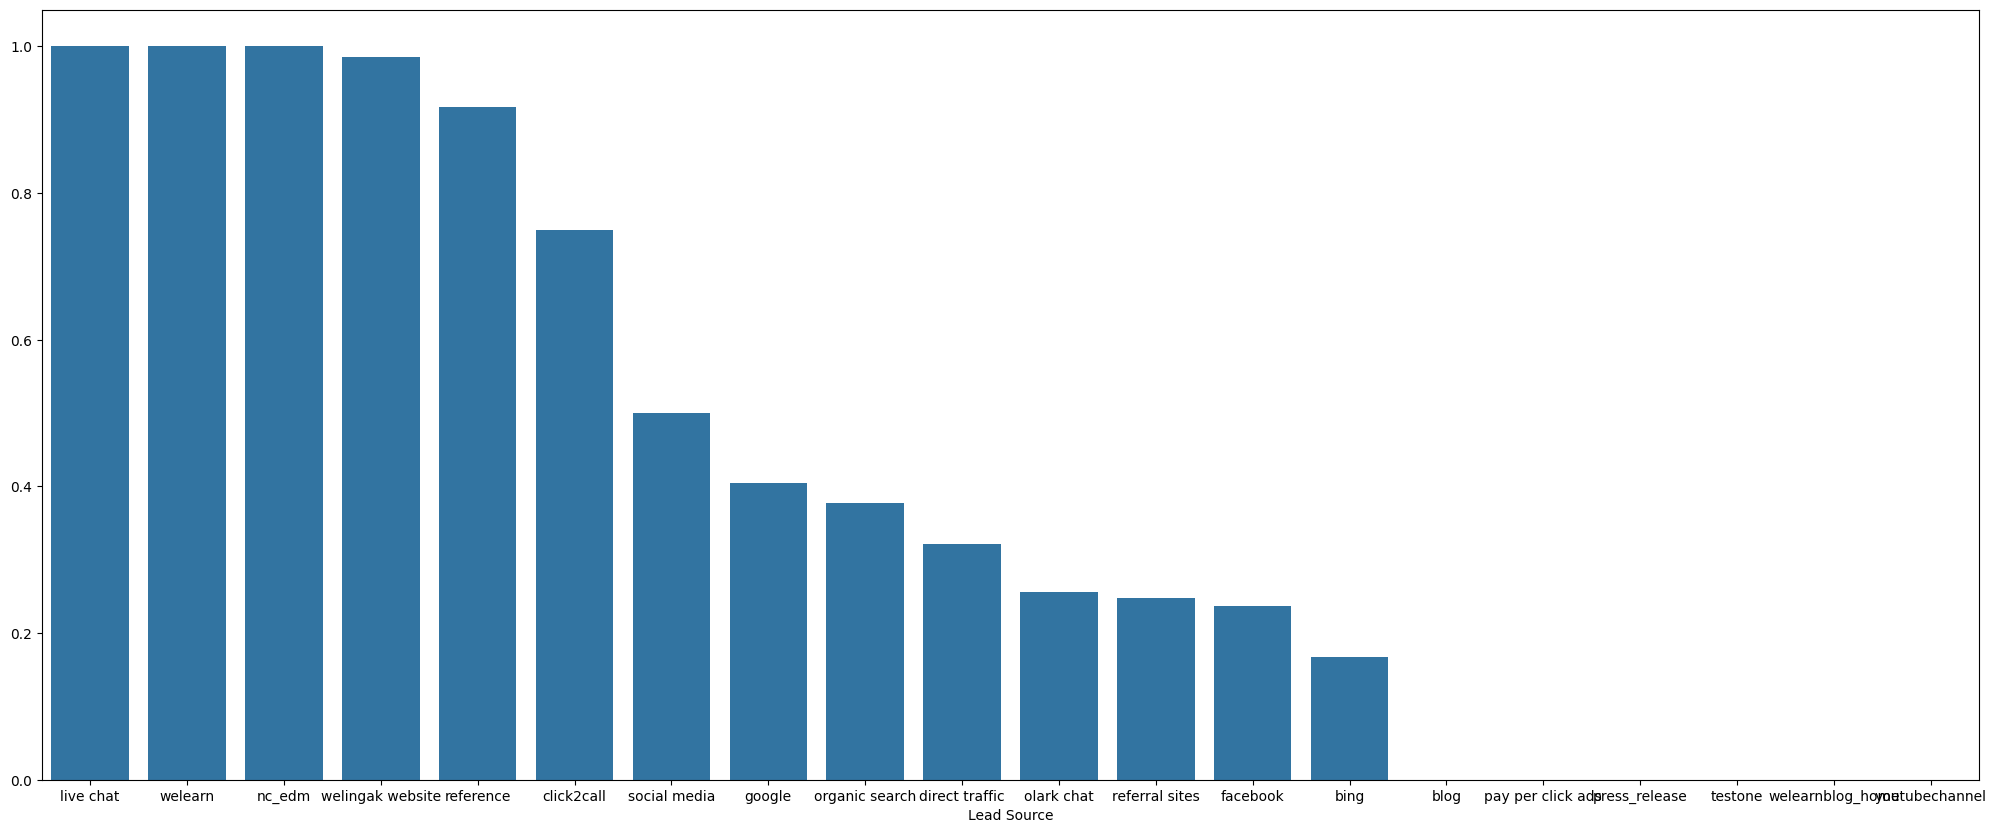

In [ ]:
df['Lead Source'] = df['Lead Source'].str.lower().str.strip()
conv_by_source = df.groupby('Lead Source')['Converted'].mean().sort_values(ascending=False)
plt.figure(figsize=(25, 10))
sns.barplot(x=conv_by_source.index, y=conv_by_source.values)


# Visualisations

                              count   mean    std   min   25%    50%    75%  \
TotalVisits                 9240.00   3.44   4.82  0.00  1.00   3.00   5.00   
Total Time Spent on Website 9240.00 487.70 548.02  0.00 12.00 248.00 936.00   
Page Views Per Visit        9240.00   2.36   2.15  0.00  1.00   2.00   3.00   
Asymmetrique Activity Score 9240.00   7.32   7.69 -1.00 -1.00  13.00  14.00   
Asymmetrique Profile Score  9240.00  16.10   1.36 11.00 15.80  15.80  16.00   
Converted                   9240.00   0.39   0.49  0.00  0.00   0.00   1.00   

                                max  median  variance  skewness  kurtosis  
TotalVisits                  251.00    3.00     23.22     20.06    866.25  
Total Time Spent on Website 2272.00  248.00 300327.53      0.96     -0.40  
Page Views Per Visit          55.00    2.00      4.60      2.90     43.04  
Asymmetrique Activity Score   18.00   13.00     59.18     -0.12     -1.92  
Asymmetrique Profile Score    20.00   15.80      1.86      0.81   

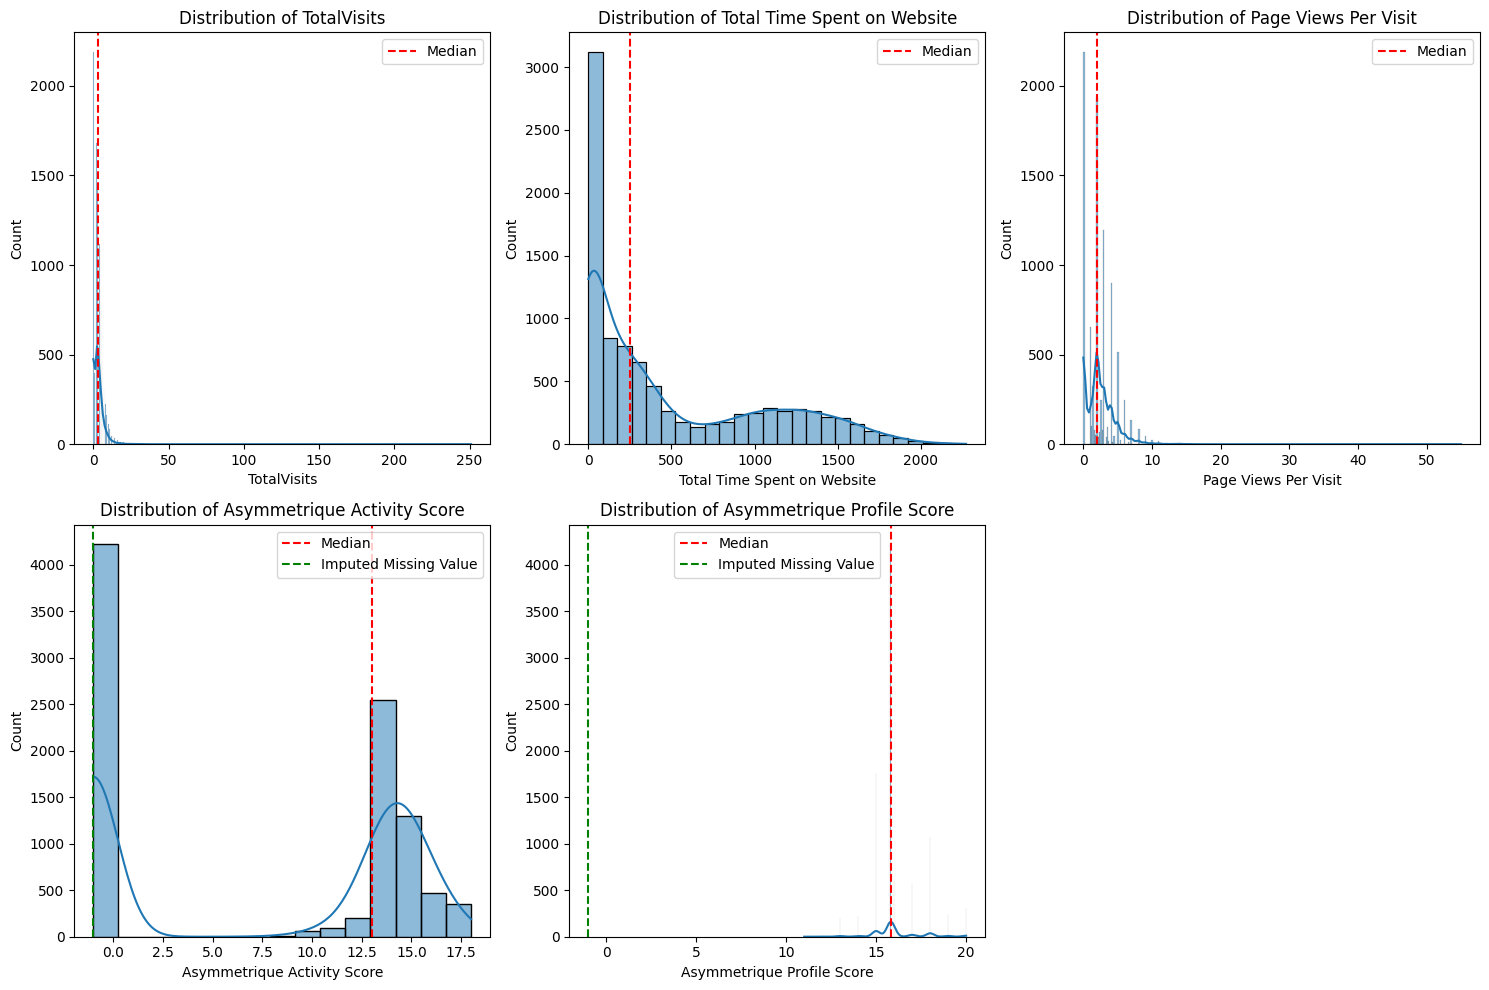

In [ ]:
# Descriptive Statistics and Histograms

# Selected numeric columns for summary and visualization
eda_cols = [
    'TotalVisits', 'Total Time Spent on Website', 'Page Views Per Visit',
    'Asymmetrique Activity Score', 'Asymmetrique Profile Score', 'Converted'
]

# Generate detailed stats
stats_df = df[eda_cols].describe().T
stats_df['median'] = df[eda_cols].median()
stats_df['variance'] = df[eda_cols].var()
stats_df['skewness'] = df[eda_cols].skew()
stats_df['kurtosis'] = df[eda_cols].kurtosis()
print(stats_df)

# Plot histograms
plt.figure(figsize=(15, 10))
for i, col in enumerate(eda_cols[:-1]):  # Skip 'Converted' for histogram
    plt.subplot(2, 3, i+1)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.axvline(df[col].median(), color='red', linestyle='--', label='Median')
    if col in ['Asymmetrique Activity Score', 'Asymmetrique Profile Score']:
        plt.axvline(-1, color='green', linestyle='--', label='Imputed Missing Value')
    plt.legend()
plt.tight_layout()
plt.show()



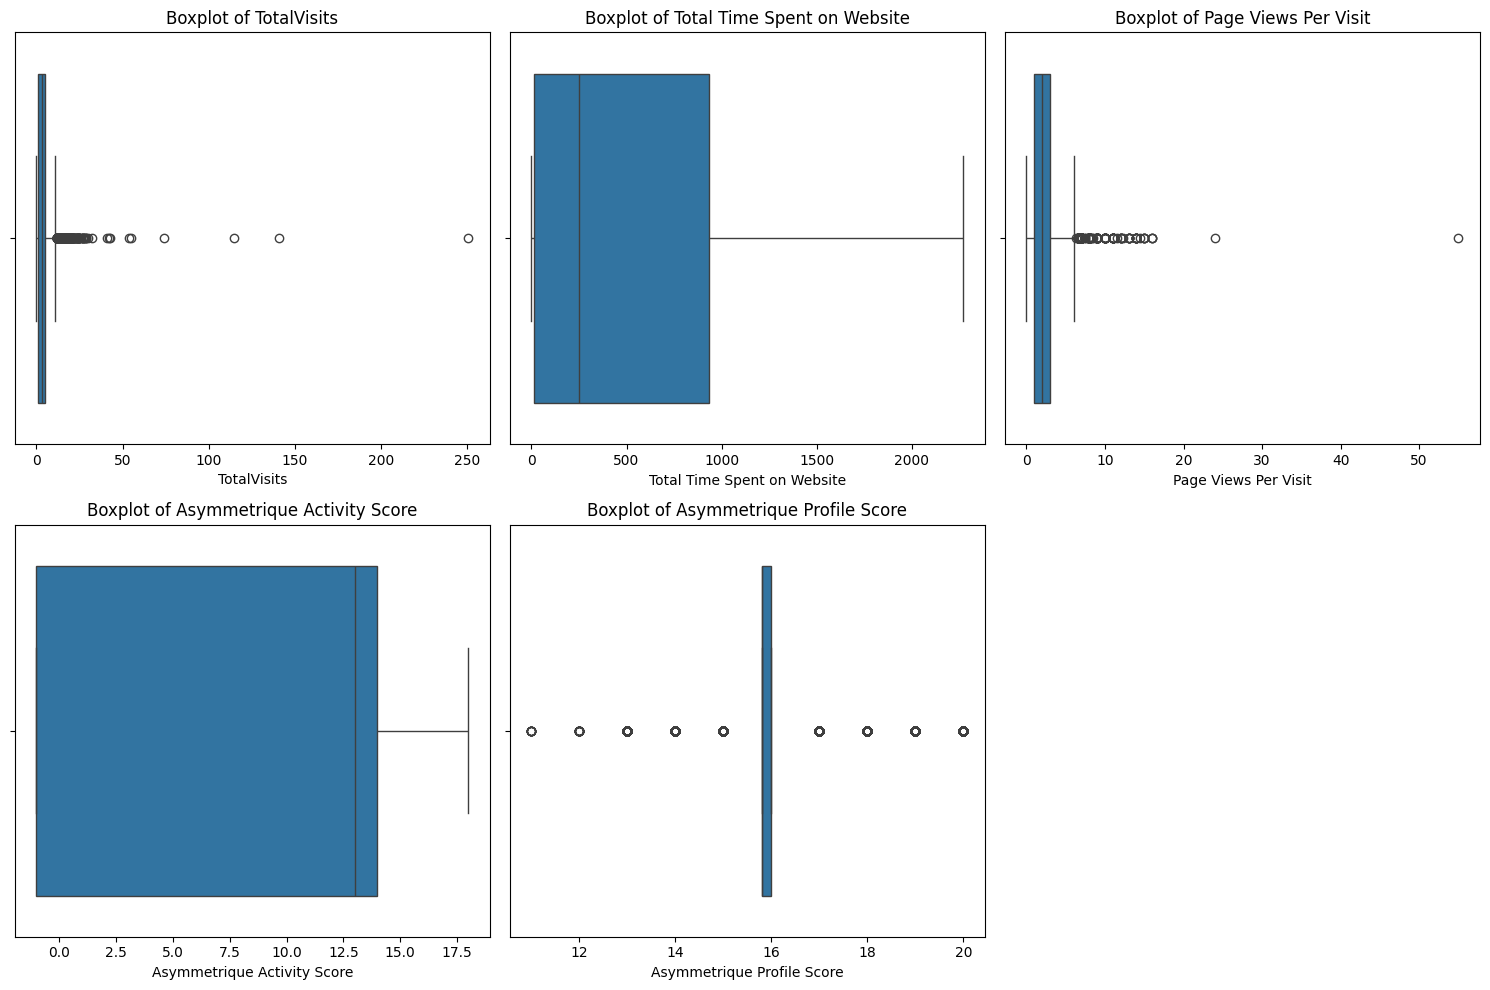

In [ ]:
# Box Plots to Visualize Outliers
plt.figure(figsize=(15, 10))
for i, col in enumerate(eda_cols[:-1]):  # Skip 'Converted'
    plt.subplot(2, 3, i+1)
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()


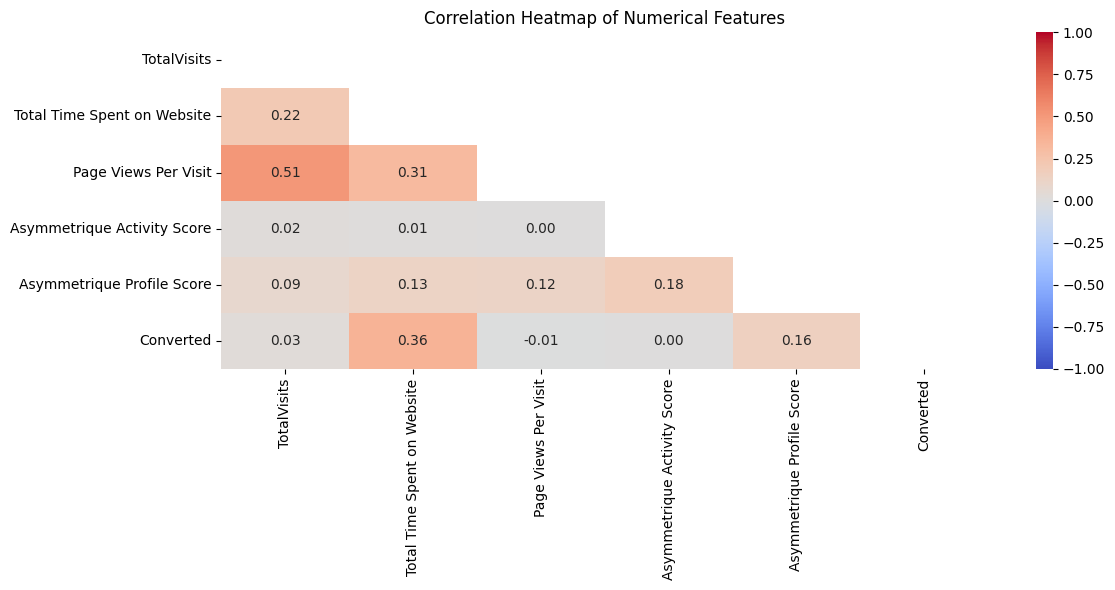

In [ ]:
# Correlation Heatmap

plt.figure(figsize=(12, 6))
corr = df[eda_cols].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title("Correlation Heatmap of Numerical Features")
plt.tight_layout()
plt.show()


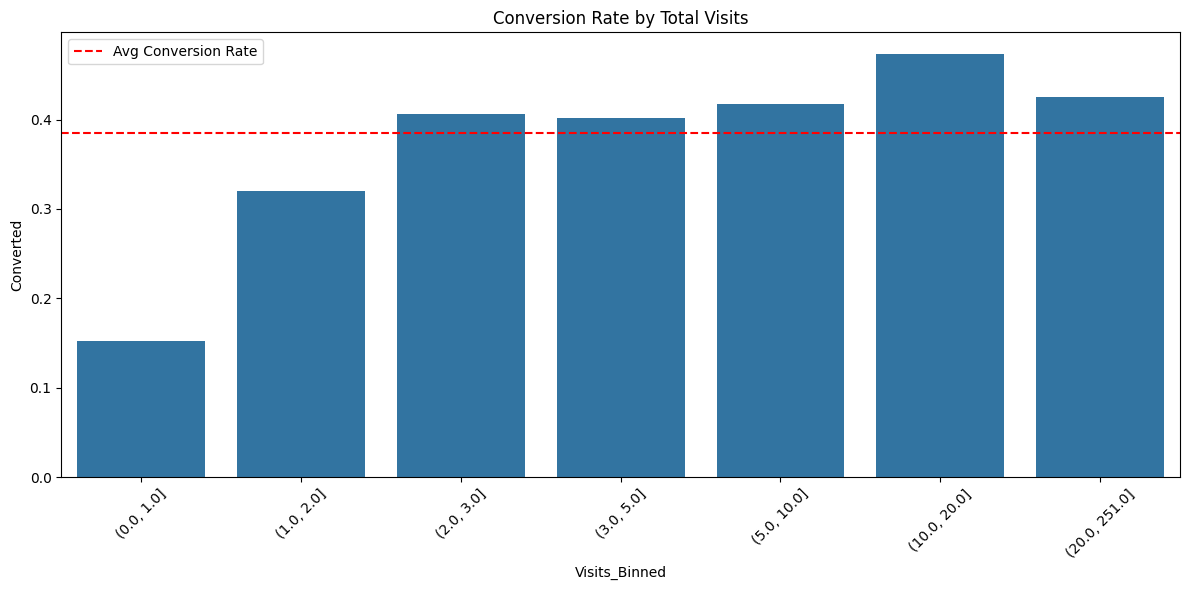

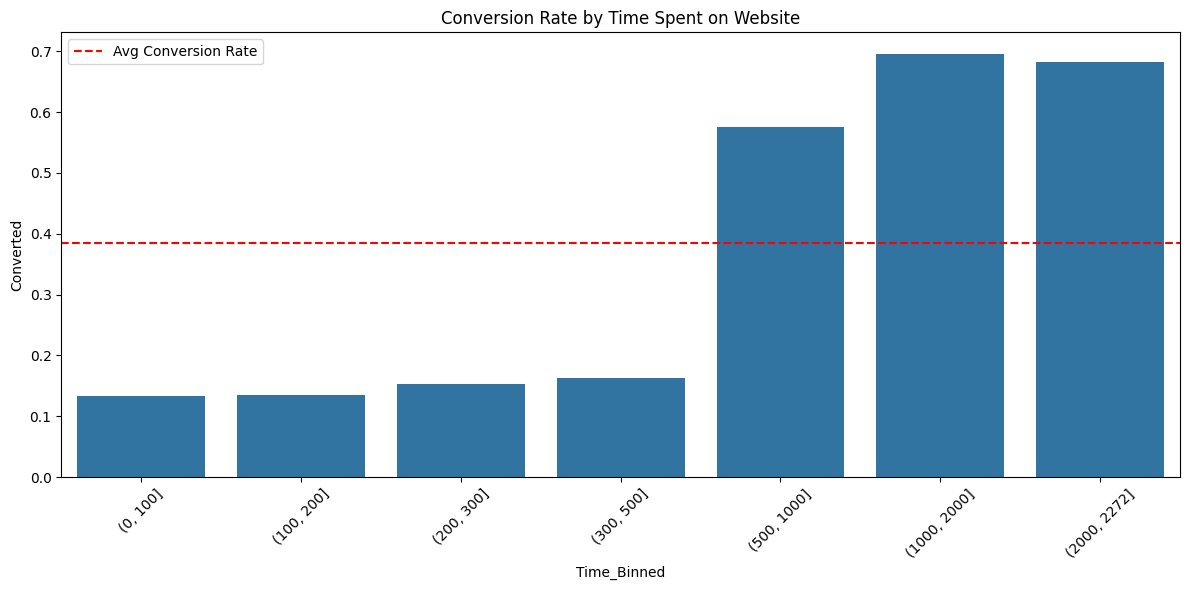

In [ ]:
# Conversion Analysis by Binned Features

# Binned Visits
df['Visits_Binned'] = pd.cut(df['TotalVisits'], bins=[0, 1, 2, 3, 5, 10, 20, df['TotalVisits'].max()])
visits_conv = df.groupby('Visits_Binned', observed=True)['Converted'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='Visits_Binned', y='Converted', data=visits_conv)
plt.axhline(y=df['Converted'].mean(), color='red', linestyle='--', label='Avg Conversion Rate')
plt.title("Conversion Rate by Total Visits")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Binned Time Spent
df['Time_Binned'] = pd.cut(df['Total Time Spent on Website'], bins=[0, 100, 200, 300, 500, 1000, 2000, df['Total Time Spent on Website'].max()])
time_conv = df.groupby('Time_Binned', observed=True)['Converted'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='Time_Binned', y='Converted', data=time_conv)
plt.axhline(y=df['Converted'].mean(), color='red', linestyle='--', label='Avg Conversion Rate')
plt.title("Conversion Rate by Time Spent on Website")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


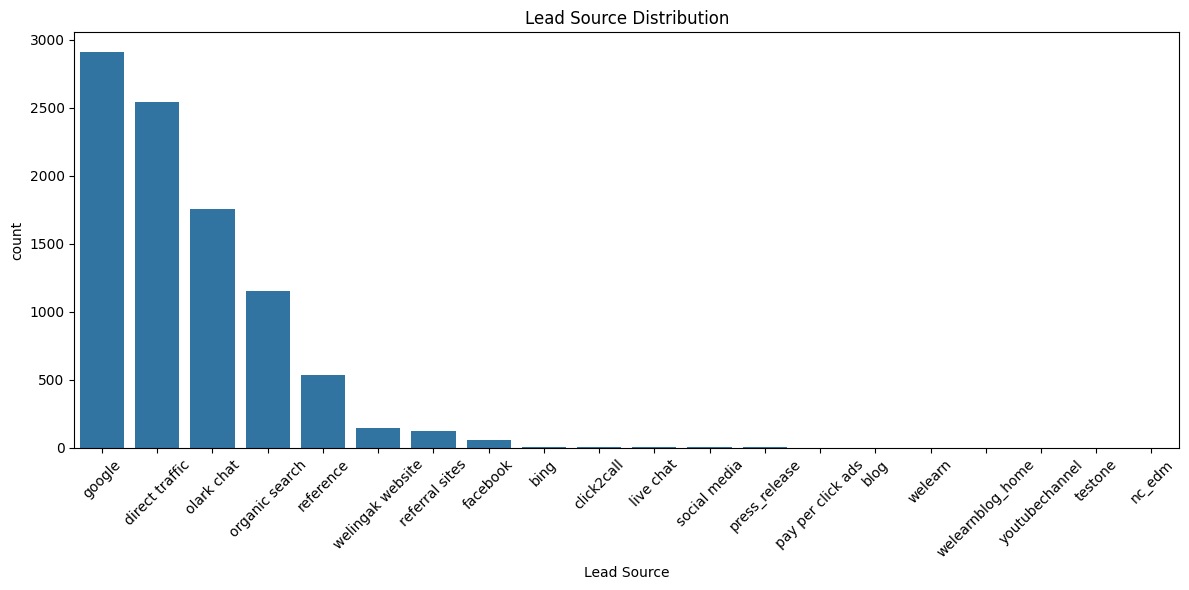

In [ ]:
# Distribution of Lead Source
plt.figure(figsize=(12, 6))
sns.countplot(x='Lead Source', data=df, order=df['Lead Source'].value_counts().index)
plt.title('Lead Source Distribution')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# Displaying variance for each feature
sorted_variance = numerical_stats[['variance']].sort_values(by='variance', ascending=False)
print("Variance for each feature:\n", sorted_variance)

Variance for each feature:
                              variance
Asymmetrique Activity Score     59.18
Asymmetrique Profile Score       1.86


In [ ]:
# Identifying the feature with the highest variance
highest_variance_feature = numerical_stats['variance'].idxmax()
highest_variance_value = numerical_stats.loc[highest_variance_feature, 'variance']
print(f"The feature with the highest variance is: {highest_variance_feature} with a variance of {highest_variance_value:.2f}")


The feature with the highest variance is: Asymmetrique Activity Score with a variance of 59.18


In [ ]:
# Scaling 'TotalVisits' using Min-Max Scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df['TotalVisits_Scaled'] = scaler.fit_transform(df[['TotalVisits']])
print(df[['TotalVisits', 'TotalVisits_Scaled']].head())


   TotalVisits  TotalVisits_Scaled
0         0.00                0.00
1         5.00                0.02
2         2.00                0.01
3         1.00                0.00
4         2.00                0.01


In [ ]:
# Creating a pivot table summarizing 'Total Time Spent on Website' by 'Lead Source'
pivot_table = pd.pivot_table(df, values='Total Time Spent on Website', index='Lead Source', aggfunc='mean')
print(pivot_table)


                   Total Time Spent on Website
Lead Source                                   
bing                                    265.67
blog                                    677.00
click2call                              509.00
direct traffic                          605.91
facebook                                247.42
google                                  649.25
live chat                                 0.00
nc_edm                                  931.00
olark chat                               61.31
organic search                          627.13
pay per click ads                       125.00
press_release                           805.00
reference                               250.15
referral sites                          540.70
social media                            553.00
testone                                 304.00
welearn                                1184.00
welearnblog_home                        368.00
welingak website                        143.18
youtubechanne

# Processing Data
## Converting Yes/No Columns to Binary

In [ ]:
#Converting Yes/No columns to binary
binary_columns = ['Do Not Email', 'Do Not Call', 'Get updates on DM Content',
                  'I agree to pay the amount through cheque', 'A free copy of Mastering The Interview']

for col in binary_columns:
    df[col] = df[col].map({'Yes': 1, 'No': 0})

print(df.head())


                            Prospect ID  Lead Number              Lead Origin  \
0  7927b2df-8bba-4d29-b9a2-b6e0beafe620       660737                      API   
1  2a272436-5132-4136-86fa-dcc88c88f482       660728                      API   
2  8cc8c611-a219-4f35-ad23-fdfd2656bd8a       660727  Landing Page Submission   
3  0cc2df48-7cf4-4e39-9de9-19797f9b38cc       660719  Landing Page Submission   
4  3256f628-e534-4826-9d63-4a8b88782852       660681  Landing Page Submission   

      Lead Source  Do Not Email  Do Not Call  Converted  TotalVisits  \
0      olark chat             0            0          0         0.00   
1  organic search             0            0          0         5.00   
2  direct traffic             0            0          1         2.00   
3  direct traffic             0            0          0         1.00   
4          google             0            0          1         2.00   

   Total Time Spent on Website  Page Views Per Visit  ...  \
0                  

## Handling NaN values

In [ ]:
# Replace Placeholder Strings with NaN
# For the specified categorical columns, replace variations of "Unknown" with np.nan.

placeholder_str_columns = [
    'Lead Quality', 'Country', 'How did you hear about X Education',
    'What is your current occupation', 'What matters most to you in choosing a course',
    'Lead Profile', 'Tags', 'City',
    'Asymmetrique Activity Index', 'Asymmetrique Profile Index'
]
for col in placeholder_str_columns:
    if col in df.columns:
        df[col] = df[col].replace(['Unknown', 'unknown'], np.nan)  # Replaced placeholder strings with NaN



In [ ]:
# Replace Placeholder Numeric Values with NaN
# For the listed numerical columns, replace the placeholder value -1 with np.nan.

placeholder_numeric_columns = ['Asymmetrique Activity Score']
for col in placeholder_numeric_columns:
    if col in df.columns:
        df[col] = df[col].replace(-1, np.nan)  # Replaced -1 with NaN



Columns to drop

In [ ]:
# 4. Data Quality Check and Dropping Highly Incomplete Columns
# First, we display the data quality report. Then, we calculate the percentage of missing values
# and drop columns with more than 70% missing values.

print(data_quality_report(df))  # Display data quality report

missing_percent = df.isnull().mean()  # Calculate missing percentages per column
columns_to_drop = missing_percent[missing_percent > 0.70].index.tolist()  # Identify problematic columns
print("Columns to drop (more than 70% missing):", columns_to_drop)

df = df.drop(columns=columns_to_drop)  # Drop columns with >70% missing values
print("Remaining columns after dropping:", df.columns.tolist())


                                           Column  Total Count  Missing Count  \
0                                     Prospect ID         9240              0   
1                                     Lead Number         9240              0   
2                                     Lead Origin         9240              0   
3                                     Lead Source         9240              0   
4                                    Do Not Email         9240              0   
5                                     Do Not Call         9240              0   
6                                       Converted         9240              0   
7                                     TotalVisits         9240              0   
8                     Total Time Spent on Website         9240              0   
9                            Page Views Per Visit         9240              0   
10                                  Last Activity         9240              0   
11                          

In [ ]:
# 5. Drop Unused Columns
# Remove columns that are not used in the lead scoring model to keep the dataset manageable.

unused_columns = [
    'Prospect ID', 'Lead Number', 'Visits_Binned',
    'Time_Bins', 'TotalVisits_Scaled'
]
df = df.drop(unused_columns, axis=1, errors='ignore')  # Removed non-essential columns


In [ ]:
# 6. Identify and Impute Missing Values
# Here we first list columns with missing values. Then, we impute missing data:
# - Categorical columns are filled with their most frequent value (mode).
# - Numerical columns are filled with their median.

# %%
print("Missing values by column:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])  # Display only columns with missing values

# %%
# Impute categorical columns with mode values
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    mode_val = df[col].mode()[0]  # Determine mode for the column
    df[col] = df[col].fillna(mode_val)  # Imputed missing categorical values with mode
    print(f"Filled missing values in '{col}' with mode: {mode_val}")

# %%
# Impute numerical columns with median values
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
for col in numerical_cols:
    median_val = df[col].median()  # Determine median for the column
    df[col] = df[col].fillna(median_val)  # Imputed missing numerical values with median
    print(f"Filled missing values in '{col}' with median: {median_val}")


Missing values by column:
Country                                          2466
How did you hear about X Education               2207
What is your current occupation                  2690
What matters most to you in choosing a course    2709
Tags                                             3353
Lead Quality                                     4767
Lead Profile                                     2709
City                                             1420
Asymmetrique Activity Index                      4218
Asymmetrique Profile Index                       4218
Asymmetrique Activity Score                      4218
Time_Binned                                      2193
dtype: int64
Filled missing values in 'Lead Origin' with mode: Landing Page Submission
Filled missing values in 'Lead Source' with mode: google
Filled missing values in 'Last Activity' with mode: Email Opened
Filled missing values in 'Country' with mode: India
Filled missing values in 'Specialization' with mode: Select
Fille

In [ ]:
# 7. Final Checks: Missing and Infinite Values
# Confirm that there are no remaining missing values and check for any infinite
# values that might affect further modelling.

print("\nRemaining missing values after imputation:")
total_missing = df.isnull().sum().sum()  # Total missing count in the DataFrame
print(total_missing)

print("\nChecking for infinite values:")
# Identify infinite values in all float columns
inf_values = np.isinf(df.select_dtypes(include=['float64']).values).sum()
print(f"Number of infinite values: {inf_values}")



Remaining missing values after imputation:
2193

Checking for infinite values:
Number of infinite values: 0


Overall Conversion Rate: 0.3853896103896104
Lead Source Conversion Stats with Ranking:
          Lead Source  Count  Conversion_Rate  Estimated_Conversions  Rank
5              google   2909             0.40                1176.00     1
3      direct traffic   2543             0.32                 818.00     2
12          reference    534             0.92                 490.00     3
8          olark chat   1755             0.26                 448.00     4
9      organic search   1154             0.38                 436.00     5
18   welingak website    142             0.99                 140.00     6
13     referral sites    125             0.25                  31.00     7
4            facebook     55             0.24                  13.00     8
2          click2call      4             0.75                   3.00     9
6           live chat      2             1.00                   2.00    10
16            welearn      1             1.00                   1.00    11
0            

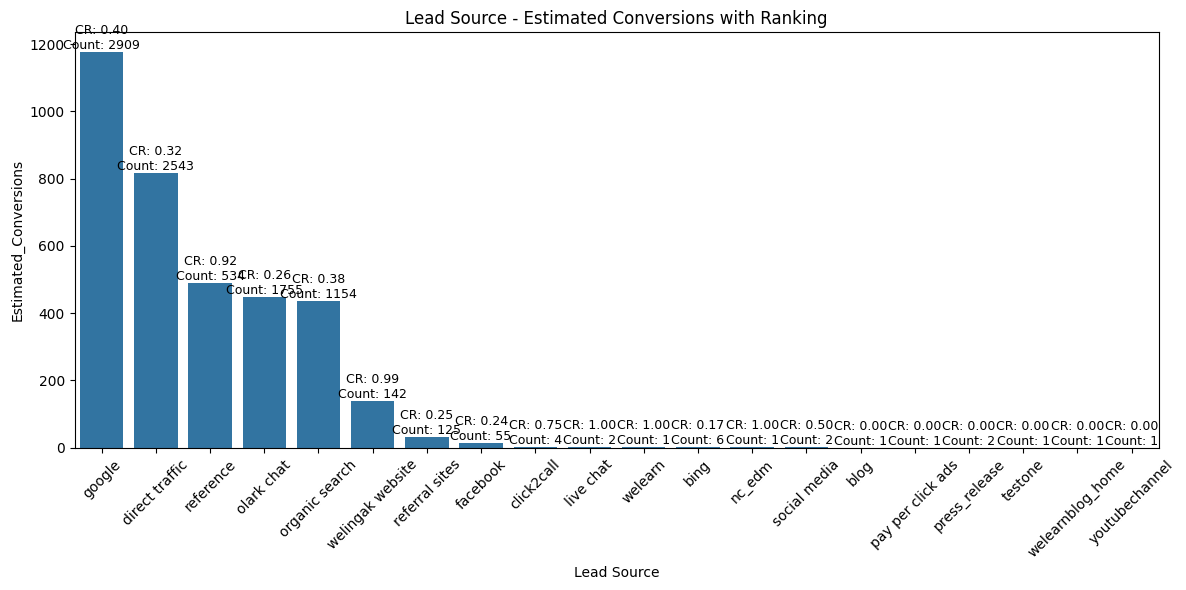

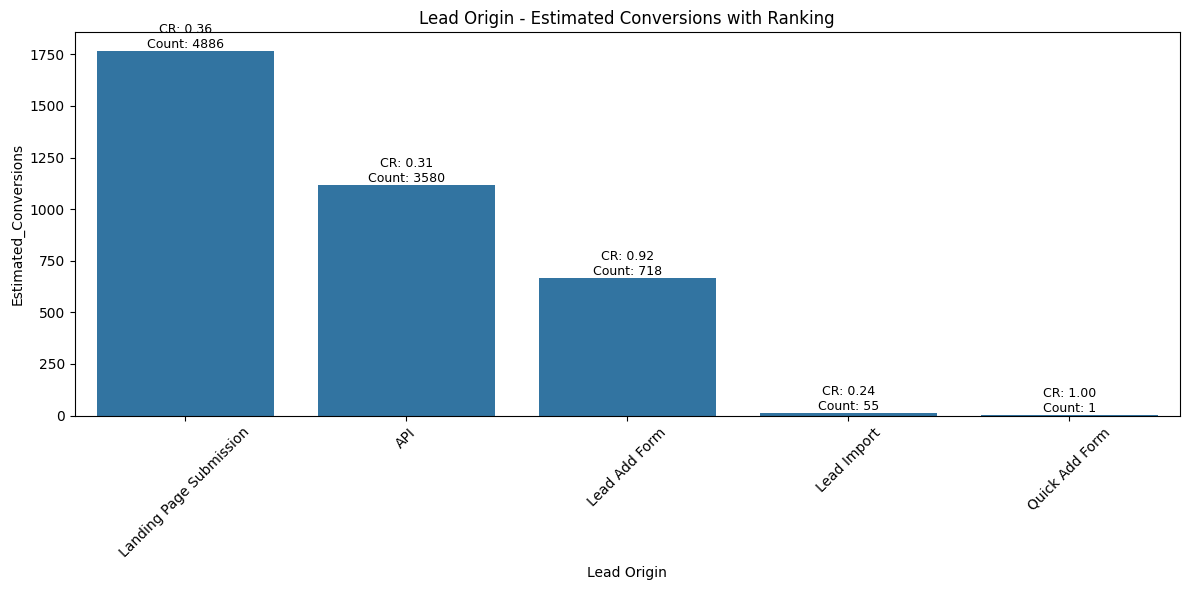

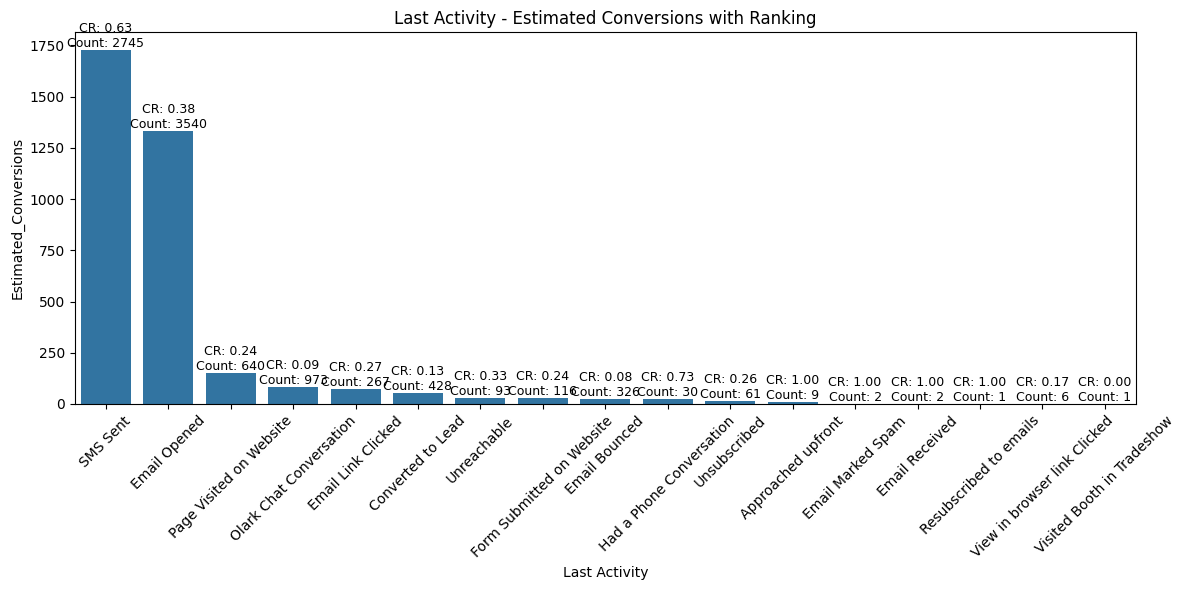

In [ ]:
# 1. Overall Conversion Rate
conversion_rate = df['Converted'].mean()
print("Overall Conversion Rate:", conversion_rate)

# 2. Aggregating conversion stats for Lead Source
lead_source_stats = df.groupby('Lead Source').agg(
    Count=('Converted', 'size'),
    Conversion_Rate=('Converted', 'mean')
).reset_index()

# Compute the estimated conversions and sort by it
lead_source_stats['Estimated_Conversions'] = lead_source_stats['Count'] * lead_source_stats['Conversion_Rate']
lead_source_stats = lead_source_stats.sort_values(by='Estimated_Conversions', ascending=False)
lead_source_stats['Rank'] = lead_source_stats['Estimated_Conversions'].rank(ascending=False, method='dense').astype(int)

print("Lead Source Conversion Stats with Ranking:")
print(lead_source_stats)

# 3. Aggregating conversion stats for Lead Origin (if available)
if 'Lead Origin' in df.columns:
    lead_origin_stats = df.groupby('Lead Origin').agg(
        Count=('Converted', 'size'),
        Conversion_Rate=('Converted', 'mean')
    ).reset_index()
    lead_origin_stats['Estimated_Conversions'] = lead_origin_stats['Count'] * lead_origin_stats['Conversion_Rate']
    lead_origin_stats = lead_origin_stats.sort_values(by='Estimated_Conversions', ascending=False)
    lead_origin_stats['Rank'] = lead_origin_stats['Estimated_Conversions'].rank(ascending=False, method='dense').astype(int)

    print("Lead Origin Conversion Stats with Ranking:")
    print(lead_origin_stats)

# 4. Aggregating conversion stats for Last Activity
last_activity_stats = df.groupby('Last Activity').agg(
    Count=('Converted', 'size'),
    Conversion_Rate=('Converted', 'mean')
).reset_index()
last_activity_stats['Estimated_Conversions'] = last_activity_stats['Count'] * last_activity_stats['Conversion_Rate']
last_activity_stats = last_activity_stats.sort_values(by='Estimated_Conversions', ascending=False)
last_activity_stats['Rank'] = last_activity_stats['Estimated_Conversions'].rank(ascending=False, method='dense').astype(int)

print("Last Activity Conversion Stats with Ranking:")
print(last_activity_stats)

# ---- Visualizations ----

# Helper function to annotate bar plots with conversion rate and count
def annotate_bars(ax, data, y_col='Estimated_Conversions'):
    for i, row in enumerate(data.itertuples()):
        ax.text(i, row._asdict()[y_col],
                f"CR: {row.Conversion_Rate:.2f}\nCount: {row.Count}",
                ha="center", va="bottom", fontsize=9)

# Visual: Lead Source
plt.figure(figsize=(12,6))
ax_ls = sns.barplot(data=lead_source_stats, x='Lead Source', y='Estimated_Conversions', order=lead_source_stats['Lead Source'])
plt.title('Lead Source - Estimated Conversions with Ranking')
plt.xticks(rotation=45)
annotate_bars(ax_ls, lead_source_stats)
plt.tight_layout()
plt.show()

# Visual: Lead Origin (if available)
if 'Lead Origin' in df.columns:
    plt.figure(figsize=(12,6))
    ax_lo = sns.barplot(data=lead_origin_stats, x='Lead Origin', y='Estimated_Conversions', order=lead_origin_stats['Lead Origin'])
    plt.title('Lead Origin - Estimated Conversions with Ranking')
    plt.xticks(rotation=45)
    annotate_bars(ax_lo, lead_origin_stats)
    plt.tight_layout()
    plt.show()

# Visual: Last Activity
plt.figure(figsize=(12,6))
ax_la = sns.barplot(data=last_activity_stats, x='Last Activity', y='Estimated_Conversions', order=last_activity_stats['Last Activity'])
plt.title('Last Activity - Estimated Conversions with Ranking')
plt.xticks(rotation=45)
annotate_bars(ax_la, last_activity_stats)
plt.tight_layout()
plt.show()



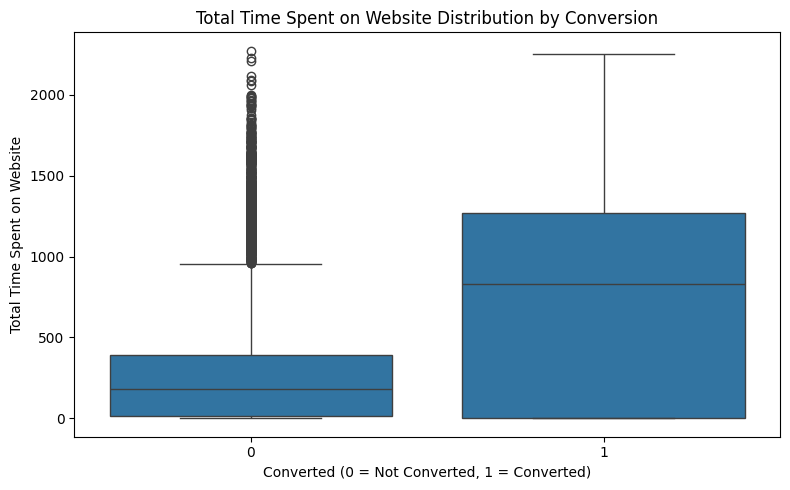

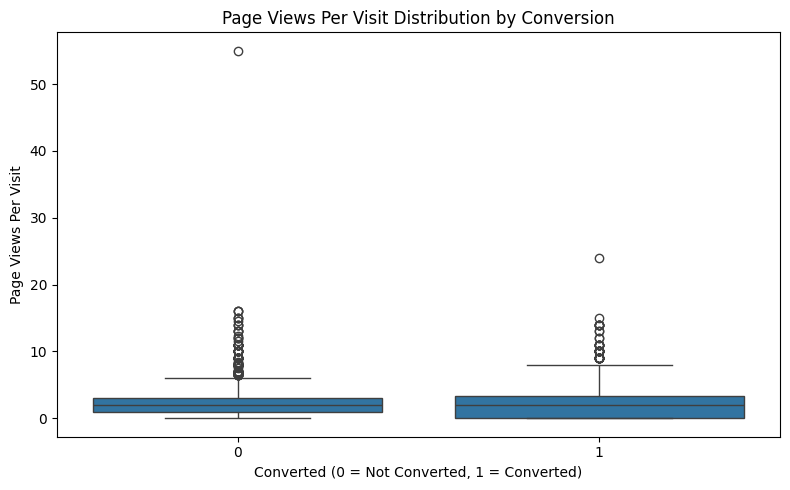

In [ ]:
#3. Numeric Feature Distributions by Conversion Status
# We examine how features like Total Visits, Total Time Spent on Website, and Page Views Per Visit differ between converted and non-converted leads.

numeric_features = ['Total Visits', 'Total Time Spent on Website', 'Page Views Per Visit']
for feature in numeric_features:
    if feature in df.columns:
        plt.figure(figsize=(8,5))
        sns.boxplot(x="Converted", y=feature, data=df)
        plt.title(f"{feature} Distribution by Conversion")
        plt.xlabel("Converted (0 = Not Converted, 1 = Converted)")
        plt.ylabel(feature)
        plt.tight_layout()
        plt.show()

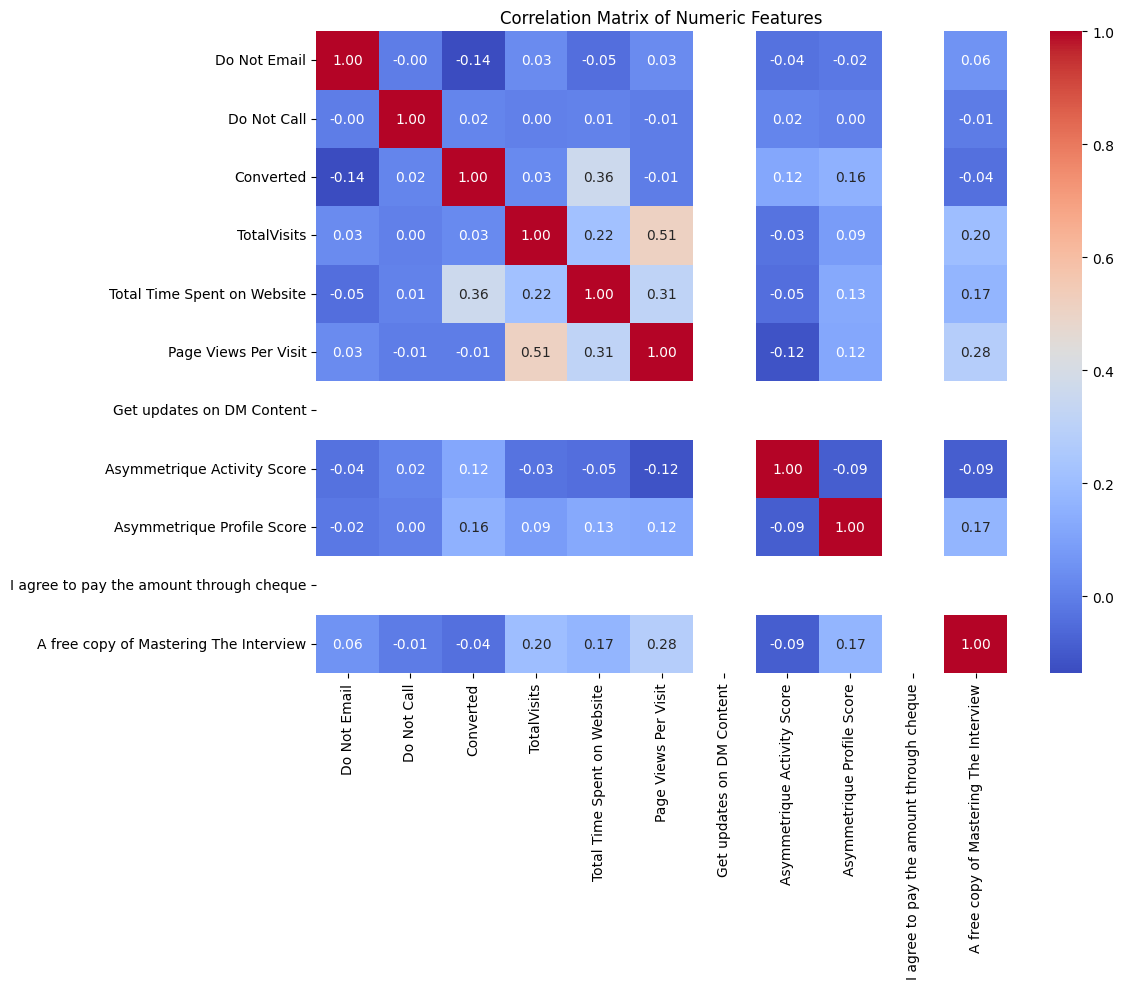

In [ ]:
# 4. Correlation Analysis for Numeric Features
# We plot a heatmap of the numeric variables to visualize their correlations
# (including the target variable 'Converted', to see which ones are most strongly related).

numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
corr_matrix = df[numeric_cols].corr()

plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix of Numeric Features")
plt.tight_layout()
plt.show()

In [ ]:
df.head()

,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,...,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity,Time_Binned
0,API,olark chat,0,0,0,0.00,0,0.00,Page Visited on Website,India,...,Select,Select,02.Medium,02.Medium,15.00,15.00,0,0,Modified,NaN
1,API,organic search,0,0,0,5.00,674,2.50,Email Opened,India,...,Select,Select,02.Medium,02.Medium,15.00,15.00,0,0,Email Opened,"(500.0, 1000.0]"
2,Landing Page Submission,direct traffic,0,0,1,2.00,1532,2.00,Email Opened,India,...,Potential Lead,Mumbai,02.Medium,01.High,14.00,20.00,0,1,Email Opened,"(1000.0, 2000.0]"
3,Landing Page Submission,direct traffic,0,0,0,1.00,305,1.00,Unreachable,India,...,Select,Mumbai,02.Medium,01.High,13.00,17.00,0,0,Modified,"(300.0, 500.0]"
4,Landing Page Submission,google,0,0,1,2.00,1428,1.00,Converted to Lead,India,...,Select,Mumbai,02.Medium,01.High,15.00,18.00,0,0,Modified,"(1000.0, 2000.0]"


# Splitting the Data

In [ ]:
# Step h) Split the dataset into training and test sets (70-30 split)

# First, prepare the data for modeling
# Drop unnecessary columns that won't be used in the model
df = df.drop(['Prospect ID', 'Lead Number', 'Visits_Binned', 'Time_Bins', 'TotalVisits_Scaled'], axis=1, errors='ignore')

print("Remaining missing values in the dataset:")
print(df.isnull().sum().sum())


Remaining missing values in the dataset:
2193


# Encoding Categorical Variables

In [ ]:
# Encoding categorical variables
# Get dummies for categorical variables
df_encoded = pd.get_dummies(df, drop_first=True)
print("Shape after encoding:", df_encoded.shape)

# Prepare features (X) and target variable (y)
X = df_encoded.drop('Converted', axis=1)
y = df_encoded['Converted']

Shape after encoding: (9240, 191)


In [ ]:
# Split the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (6468, 190)
Test set shape: (2772, 190)


# Applying Feature Scaling to address convergences issues for RFE

In [ ]:
# Apply feature scaling to address convergence issues
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Convert back to DataFrame to keep column names
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Performing RFE

In [ ]:
# ---------------------------
# Feature Selection with RFE
logreg = LogisticRegression(max_iter=5000, solver='liblinear', C=1.0)
print("Using LogisticRegression with solver='liblinear' and max_iter=5000")

# Perform RFE selecting the top 15 features
rfe = RFE(estimator=logreg, n_features_to_select=15)
rfe.fit(X_train_scaled, y_train)

# Retrieve the selected features from RFE
selected_features = X_train.columns[rfe.support_]
print("Selected features by RFE:")
for i, feature in enumerate(selected_features):
    print(f"{i+1}. {feature}")

# Build datasets with only the selected features
X_train_rfe = X_train_scaled[selected_features]
X_test_rfe = X_test_scaled[selected_features]

# Function to calculate VIF (Variance Inflation Factor)
def calculate_vif(X):
    vif_df = pd.DataFrame({
        "feature": X.columns,
        "VIF": [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    })
    return vif_df.sort_values(by="VIF", ascending=False)

# Initial VIF calculation
vif_df = calculate_vif(X_train_rfe)
print("Initial VIF values:\n", vif_df)

# ---------------------------
# Iteratively remove features with VIF > 5
features = list(X_train_rfe.columns)
dropped_features = []
while True:
    # Calculate VIF for the current set of features
    current_vif = pd.DataFrame({
        "feature": features,
        "VIF": [variance_inflation_factor(X_train_rfe[features].values, i) for i in range(len(features))]
    })
    max_vif = current_vif["VIF"].max()
    if max_vif <= 5:
        break
    # Identify the feature with the highest VIF
    feature_to_drop = current_vif.sort_values("VIF", ascending=False).iloc[0]["feature"]
    print(f"Dropping feature '{feature_to_drop}' with VIF = {max_vif:.2f}")
    features.remove(feature_to_drop)
    dropped_features.append(feature_to_drop)

print("\nRemaining features after VIF-based elimination:")
print(features)

# Subset the training and test sets with the remaining features
X_train_rfe = X_train_rfe[features]
X_test_rfe = X_test_rfe[features]

# Optionally, recalc and display the updated VIF values
updated_vif_df = calculate_vif(X_train_rfe)
print("\nUpdated VIF values:\n", updated_vif_df)



Using LogisticRegression with solver='liblinear' and max_iter=5000
Selected features by RFE:
1. Asymmetrique Activity Score
2. Lead Source_welingak website
3. What is your current occupation_Working Professional
4. Tags_Closed by Horizzon
5. Tags_Lost to EINS
6. Tags_Will revert after reading the email
7. Lead Quality_Might be
8. Lead Quality_Worst
9. Lead Profile_Select
10. City_Select
11. Asymmetrique Activity Index_02.Medium
12. Asymmetrique Activity Index_03.Low
13. Last Notable Activity_SMS Sent
14. Time_Binned_(500, 1000]
15. Time_Binned_(1000, 2000]
Initial VIF values:
                                               feature  VIF
11                 Asymmetrique Activity Index_03.Low 5.00
0                         Asymmetrique Activity Score 4.01
10              Asymmetrique Activity Index_02.Medium 3.76
6                               Lead Quality_Might be 1.69
8                                 Lead Profile_Select 1.52
5            Tags_Will revert after reading the email 1.51
7  

In [ ]:
# Define X_train_selected based on the features selected (after removal)
X_train_selected = X_train_rfe.copy()

# Building and Refining the Logistic Regression Model

In [ ]:
# We reset the indices for alignment, add a constant column for the intercept, and build an initial logistic regression model (using 'bfgs'). Then we calculate the VIF for each feature and identify features with p-values greater than 0.05 or VIF greater than 5. If such features exist, we refine the model (dropping these features) and re-fit using the 'newton' method.

# Reset indices for training data to ensure alignment
X_train_rfe = X_train_rfe.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

# Add constant for statsmodels intercept
X_train_sm = sm.add_constant(X_train_rfe)

# Build the initial logistic regression model using 'bfgs' optimizer
logm = sm.Logit(y_train, X_train_sm).fit(method='bfgs', maxiter=200)
print(logm.summary())

# Calculate VIF values for the initial features
vif_data = pd.DataFrame({
    "Feature": X_train_rfe.columns,
    "VIF": [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
})
print("Initial VIF values:\n", vif_data.sort_values("VIF", ascending=False))

# Identify features with high p-values (excluding constant) and high VIF (>5)
high_p_features = logm.pvalues[1:][logm.pvalues[1:] > 0.05].index.tolist()
high_vif_features = vif_data[vif_data["VIF"] > 5]["Feature"].tolist()
features_to_remove = list(set(high_p_features + high_vif_features))
print("Features identified for removal:", features_to_remove)

# %%
# If there are problematic features, refine the model by dropping them from train and test sets
if features_to_remove:
    X_train_refined = X_train_rfe.drop(features_to_remove, axis=1)
    X_test_refined = X_test_rfe.drop(features_to_remove, axis=1)
    X_train_refined_sm = sm.add_constant(X_train_refined)

    # Refit logistic model with refined features using 'newton'
    logm_refined = sm.Logit(y_train, X_train_refined_sm).fit(method='newton', maxiter=100)
    print("Refined Model Summary:")
    print(logm_refined.summary())

    # Calculate VIF for the refined model
    vif_data_refined = pd.DataFrame({
        "Feature": X_train_refined.columns,
        "VIF": [variance_inflation_factor(X_train_refined.values, i) for i in range(X_train_refined.shape[1])]
    })
    print("Refined VIF values:\n", vif_data_refined.sort_values("VIF", ascending=False))
else:
    logm_refined = logm
    X_train_refined = X_train_rfe
    X_test_refined = X_test_rfe
    X_train_refined_sm = X_train_sm

# Ensure final VIF values are available in case you need them later
vif_data_refined = pd.DataFrame({
    "Feature": X_train_refined.columns,
    "VIF": [variance_inflation_factor(X_train_refined.values, i) for i in range(X_train_refined.shape[1])]
})


Optimization terminated successfully.
         Current function value: 0.223856
         Iterations: 92
         Function evaluations: 93
         Gradient evaluations: 93
                           Logit Regression Results                           
Dep. Variable:              Converted   No. Observations:                 6468
Model:                          Logit   Df Residuals:                     6453
Method:                           MLE   Df Model:                           14
Date:                Tue, 06 May 2025   Pseudo R-squ.:                  0.6639
Time:                        11:48:49   Log-Likelihood:                -1447.9
converged:                       True   LL-Null:                       -4307.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                           coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------

In [ ]:
print("Top Conversion Drivers:")
print(logm.params.sort_values(ascending=False).head(5))


Top Conversion Drivers:
Tags_Will revert after reading the email   2.47
Tags_Closed by Horizzon                    1.67
Tags_Lost to EINS                          1.46
Lead Source_welingak website               1.27
Last Notable Activity_SMS Sent             1.19
dtype: float64


# Model Evaluation and Lead Scoring
We add a constant to the test dataset (if needed) for prediction compatibility with statsmodels. After obtaining probability predictions, we evaluate the model with a default threshold of 0.5 and compute common metrics. We then calculate detailed confusion breakdowns, generate lead scores for both training and test sets, and assess metrics at alternate thresholds (0.3 and 0.421). Finally, we plot the lead score distribution and the precision-recall tradeoff, and classify leads into tiers.

In [ ]:
## Model Summary and Diagnostics
# Display the refined model summary, final VIF values, and pseudo R-squared.

print("\nModel Summary from Training Set:")
print(logm_refined.summary())
print("\nFinal VIF values from Training Set:")
print(vif_data_refined)
pseudo_r2 = logm_refined.prsquared
print(f"\nPseudo R-squared (Train): {pseudo_r2:.4f}")


Model Summary from Training Set:
                           Logit Regression Results                           
Dep. Variable:              Converted   No. Observations:                 6468
Model:                          Logit   Df Residuals:                     6454
Method:                           MLE   Df Model:                           13
Date:                Tue, 06 May 2025   Pseudo R-squ.:                  0.6574
Time:                        11:48:50   Log-Likelihood:                -1475.7
converged:                       True   LL-Null:                       -4307.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                   -1.1075      0.072    -15.301      0

In [ ]:
# Evaluation on Test Data (Threshold 0.5)

if 'const' not in X_test_refined.columns:
    X_test_refined_sm = sm.add_constant(X_test_refined, has_constant='add')
else:
    X_test_refined_sm = X_test_refined.copy()

y_pred_prob = logm_refined.predict(X_test_refined_sm)
y_pred = (y_pred_prob >= 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred)
precision_metric = precision_score(y_test, y_pred)
recall_metric = recall_score(y_test, y_pred)
f1_metric = f1_score(y_test, y_pred)
roc_auc_metric = roc_auc_score(y_test, y_pred_prob)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Test Set Evaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision_metric:.4f}")
print(f"Recall: {recall_metric:.4f}")
print(f"F1 Score: {f1_metric:.4f}")
print(f"ROC AUC: {roc_auc_metric:.4f}")
print("Confusion Matrix:")
print(conf_matrix)



Test Set Evaluation Metrics:
Accuracy: 0.9113
Precision: 0.9288
Recall: 0.8357
F1 Score: 0.8798
ROC AUC: 0.9647
Confusion Matrix:
[[1626   69]
 [ 177  900]]


In [ ]:
# Detailed Confusion Metrics for threshold 0.5
# Calculate sensitivity, specificity, and re-calculate precision.

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
precision_calc = tp / (tp + fp)

print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Precision: {precision_calc:.4f}")

Sensitivity (Recall): 0.8357
Specificity: 0.9593
Precision: 0.9288


In [ ]:
# Lead Scoring for Training Data
# Generate training probabilities, convert them to a lead score (0–100), and apply a conversion threshold of 0.3.
y_train_prob = logm_refined.predict(X_train_refined_sm)
lead_scores_train = (y_train_prob * 100).round(2)
y_train_pred_03 = (y_train_prob >= 0.3).astype(int)

train_results = pd.DataFrame({
    'Actual': y_train,
    'Predicted': y_train_pred_03,
    'Probability': y_train_prob.round(4),
    'Lead Score': lead_scores_train
})
print(train_results.head())

   Actual  Predicted  Probability  Lead Score
0       0          0         0.08        7.56
1       1          1         0.99       98.60
2       0          0         0.25       24.67
3       0          0         0.04        4.36
4       0          1         0.47       47.15


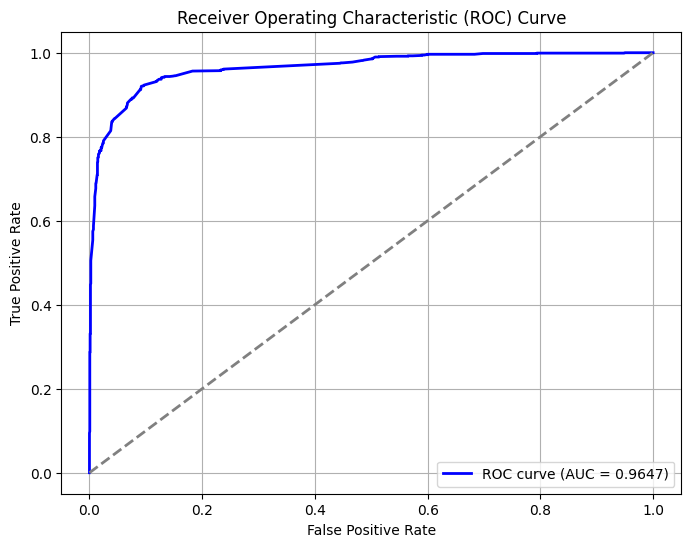

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Step 1: Get the false positive rate and true positive rate
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Step 2: Calculate the Area Under the Curve
roc_auc = auc(fpr, tpr)

# Step 3: Plot the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [ ]:
# Evaluation at 0.3 Threshold on Test Data
# Assess model predictions using a 0.3 threshold and compute confusion matrix metrics.

y_test_prob = logm_refined.predict(X_test_refined_sm)
y_test_pred_03 = (y_test_prob >= 0.3).astype(int)

conf_matrix_03 = confusion_matrix(y_test, y_test_pred_03)
tn, fp, fn, tp = conf_matrix_03.ravel()
sensitivity_03 = tp / (tp + fn)
specificity_03 = tn / (tn + fp)
precision_03 = tp / (tp + fp)
roc_auc_metric_03 = roc_auc_score(y_test, y_test_prob)
print("Confusion Matrix @ 0.3 Threshold:")
print(conf_matrix_03)
print(f"Sensitivity: {sensitivity_03:.4f}")
print(f"Specificity: {specificity_03:.4f}")
print(f"Precision: {precision_03:.4f}")
print(f"ROC AUC: {roc_auc_metric_03:.4f}")

Confusion Matrix @ 0.3 Threshold:
[[1479  216]
 [  68 1009]]
Sensitivity: 0.9369
Specificity: 0.8726
Precision: 0.8237
ROC AUC: 0.9647


In [ ]:
# Lead Scoring for Test Data
# Convert test set probabilities to lead scores and bundle into a summary DataFrame.

lead_scores_test = (y_test_prob * 100).round(2)
test_results = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_test_pred_03,
    'Probability': y_test_prob.round(4),
    'Lead Score': lead_scores_test
})

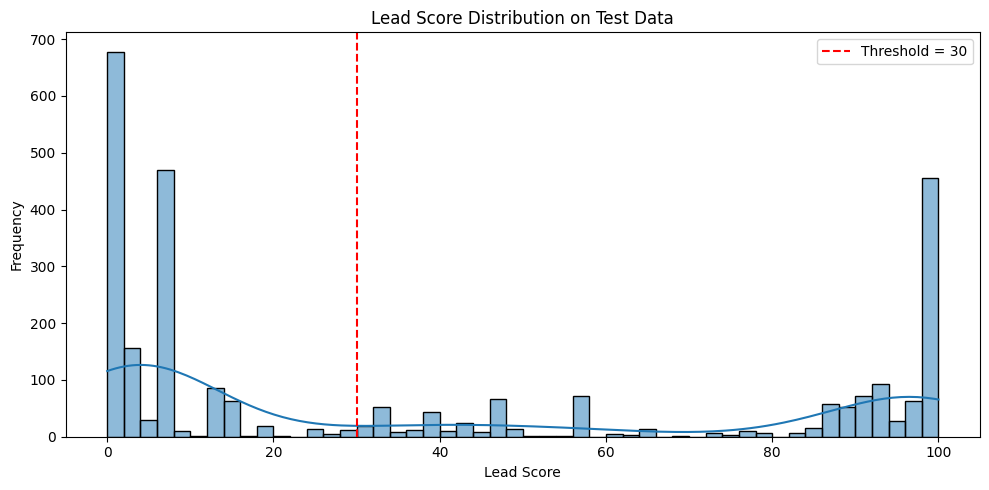

In [ ]:
## Lead Score Distribution Plot on Test Data
# Plot the distribution of lead scores with a threshold marker at 30.

plt.figure(figsize=(10, 5))
sns.histplot(lead_scores_test, bins=50, kde=True)
plt.axvline(30, color='red', linestyle='--', label='Threshold = 30')
plt.title("Lead Score Distribution on Test Data")
plt.xlabel("Lead Score")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()

## Model Stability assessment

In [ ]:
# Import necessary libraries
from sklearn.model_selection import StratifiedKFold, cross_val_score  # Import StratifiedKFold
from sklearn.linear_model import LogisticRegression

# ... (rest of your code) ...

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
lr = LogisticRegression(max_iter=5000, solver='liblinear', C=1.0)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
lr = LogisticRegression(max_iter=5000, solver='liblinear', C=1.0)

# Compute cross-validation scores for (AUC, Precision, Recall)
auc_scores = cross_val_score(lr, X_train_selected, y_train, cv=cv, scoring="roc_auc")
precision_scores = cross_val_score(lr, X_train_selected, y_train, cv=cv, scoring="precision")
recall_scores = cross_val_score(lr, X_train_selected, y_train, cv=cv, scoring="recall")

print("Cross-Validation AUC Scores:", auc_scores)# Import necessary libraries
from sklearn.model_selection import StratifiedKFold, cross_val_score  # Import StratifiedKFold
from sklearn.linear_model import LogisticRegression

# ... (rest of your code) ...

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
lr = LogisticRegression(max_iter=5000, solver='liblinear', C=1.0)
print("Mean AUC:", np.mean(auc_scores))
print("Cross-Validation Precision Scores:", precision_scores)
print("Mean Precision:", np.mean(precision_scores))
print("Cross-Validation Recall Scores:", recall_scores)
print("Mean Recall:", np.mean(recall_scores))

Cross-Validation AUC Scores: [0.96304679 0.96021171 0.96371075 0.95789402 0.97130901]
Mean AUC: 0.9632344542083858
Cross-Validation Precision Scores: [0.92087912 0.92715232 0.92374728 0.91466083 0.92291221]
Mean Precision: 0.9218703505051333
Cross-Validation Recall Scores: [0.84305835 0.84507042 0.85311871 0.84274194 0.86720322]
Mean Recall: 0.8502385279418446


We use Cross-Validation for
1. Model Robustness
2. Reducing the bias associated with any single train/test split.
* AUC : Area under the curve - The model can effectively distinguish between leads that convert and those that do not.
* Precision: he mean precision of around 0.92 means that when the model predicts a lead will convert, it is correct about 92% of the time
* Recall: The mean recall of approximately 0.851 shows that about 85% of the actual converted leads are being correctly identified by the model.

    Threshold  Precision  Recall   F1
0        0.10       0.72    0.96 0.82
1        0.15       0.79    0.95 0.86
2        0.20       0.80    0.95 0.87
3        0.25       0.81    0.94 0.87
4        0.30       0.81    0.94 0.87
5        0.35       0.85    0.92 0.88
6        0.40       0.87    0.90 0.89
7        0.45       0.88    0.89 0.88
8        0.50       0.92    0.85 0.88
9        0.55       0.93    0.84 0.88
10       0.60       0.94    0.81 0.87
11       0.65       0.95    0.79 0.87
12       0.70       0.96    0.79 0.86
13       0.75       0.96    0.78 0.86
14       0.80       0.96    0.76 0.85
15       0.85       0.97    0.73 0.83
16       0.90       0.98    0.62 0.76
17       0.95       0.98    0.50 0.66


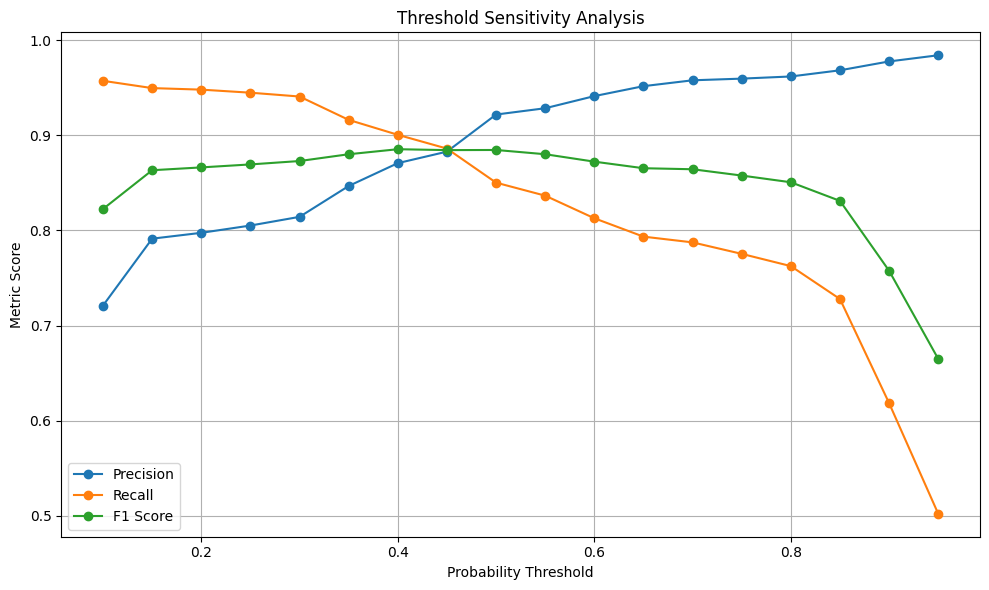

Optimal Threshold (based on F1): 0.40
Optimal Threshold from CV: 0.40
Final Test Set Results:
[[1566  129]
 [ 106  971]]
              precision    recall  f1-score   support

           0      0.937     0.924     0.930      1695
           1      0.883     0.902     0.892      1077

    accuracy                          0.915      2772
   macro avg      0.910     0.913     0.911      2772
weighted avg      0.916     0.915     0.915      2772



In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report # Importing the classification_report
from sklearn.model_selection import cross_val_predict


# Obtain cross-validated probability estimates using cross_val_predict.
# Use method='predict_proba' to get probabilities.
y_probs_cv = cross_val_predict(lr, X_train_selected, y_train, cv=cv, method="predict_proba")[:, 1]

# Define a range of thresholds to test
thresholds = np.arange(0.1, 1.0, 0.05)

# Use a list to store the metric results
results = []
for t in thresholds:
    y_pred_thresh = (y_probs_cv >= t).astype(int)
    precision = precision_score(y_train, y_pred_thresh)
    recall = recall_score(y_train, y_pred_thresh)
    f1 = f1_score(y_train, y_pred_thresh)
    results.append({
        "Threshold": t,
        "Precision": precision,
        "Recall": recall,
        "F1": f1
    })

# Convert the list of dictionaries to a DataFrame
metrics_df = pd.DataFrame(results)
print(metrics_df)

# Plot the sensitivity of metrics to threshold changes
plt.figure(figsize=(10, 6))
plt.plot(metrics_df["Threshold"], metrics_df["Precision"], marker="o", label="Precision")
plt.plot(metrics_df["Threshold"], metrics_df["Recall"], marker="o", label="Recall")
plt.plot(metrics_df["Threshold"], metrics_df["F1"], marker="o", label="F1 Score")
plt.title("Threshold Sensitivity Analysis")
plt.xlabel("Probability Threshold")
plt.ylabel("Metric Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
#  maximize F1 Score
best_idx = metrics_df['F1'].idxmax()
best_threshold = metrics_df.loc[best_idx, 'Threshold']
print(f"Optimal Threshold (based on F1): {best_threshold:.2f}")

# 1. Evaluate thresholds via cross_val_predict
y_probs_cv = cross_val_predict(lr, X_train_selected, y_train, cv=5, method="predict_proba")[:, 1]
thresholds = np.arange(0.1, 1.0, 0.05)

cv_results = []
for t in thresholds:
    y_pred_cv = (y_probs_cv >= t).astype(int)
    precision = precision_score(y_train, y_pred_cv)
    recall = recall_score(y_train, y_pred_cv)
    f1 = f1_score(y_train, y_pred_cv)
    cv_results.append({
        "Threshold": t,
        "Precision": precision,
        "Recall": recall,
        "F1": f1
    })

metrics_df = pd.DataFrame(cv_results)
best_idx = metrics_df['F1'].idxmax()
best_threshold = metrics_df.loc[best_idx, 'Threshold']
print(f"Optimal Threshold from CV: {best_threshold:.2f}")

# 2. Train final model on full training data
final_model = lr.fit(X_train_selected, y_train)

# 3. Predict on test set and apply chosen threshold
# Replace X_test_selected with X_test_rfe (or the appropriate test data)
y_test_prob = final_model.predict_proba(X_test_rfe)[:, 1]  # Using X_test_rfe
y_test_pred = (y_test_prob >= best_threshold).astype(int)

# 4. Final Evaluation
print("Final Test Set Results:")
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred, digits=3))



Threshold Sensitivity Analysis:

* Trade-Off Understanding
* Informed Decision-Making: With these insights, you can select a threshold that aligns best with your business objectives (e.g., during an aggressive conversion phase, you might accept a lower threshold to capture more leads even if precision drops slightly, whereas in other scenarios, you might set a higher threshold to avoid false positives)

Different types of threshold calculations performed
F1 score is sensitive to how the data are split. The CV threshold of 0.4 indicates that—on average—across your folds, you got the best balance (in terms of F1) at that level

In [ ]:
# Compute Intersection of Precision and Recall
# Here, we determine the threshold where the absolute difference between precision and recall
# is minimized. This is an approximation of the intersection point along the precision-recall curve.

# Compute precision-recall values and thresholds
precision_vals, recall_vals, thresholds = precision_recall_curve(y_test, y_pred_prob)

# Compute the absolute differences between precision and recall for each threshold.
# We use the first n elements of precision_vals and recall_vals because `thresholds` has length n.
abs_diff = np.abs(precision_vals[:-1] - recall_vals[:-1])

# Find the index where the difference is minimal
min_idx = np.argmin(abs_diff)

# Determine the optimal threshold and corresponding precision/recall values
optimal_threshold = thresholds[min_idx]
optimal_precision = precision_vals[min_idx]
optimal_recall = recall_vals[min_idx]

print(f"Optimal threshold (closest precision and recall): {optimal_threshold:.4f}")
print(f"Precision at optimal threshold: {optimal_precision:.4f}")
print(f"Recall at optimal threshold: {optimal_recall:.4f}")
print(f"Absolute difference: {abs_diff[min_idx]:.4f}")

Optimal threshold (closest precision and recall): 0.4321
Precision at optimal threshold: 0.8853
Recall at optimal threshold: 0.8886
Absolute difference: 0.0033


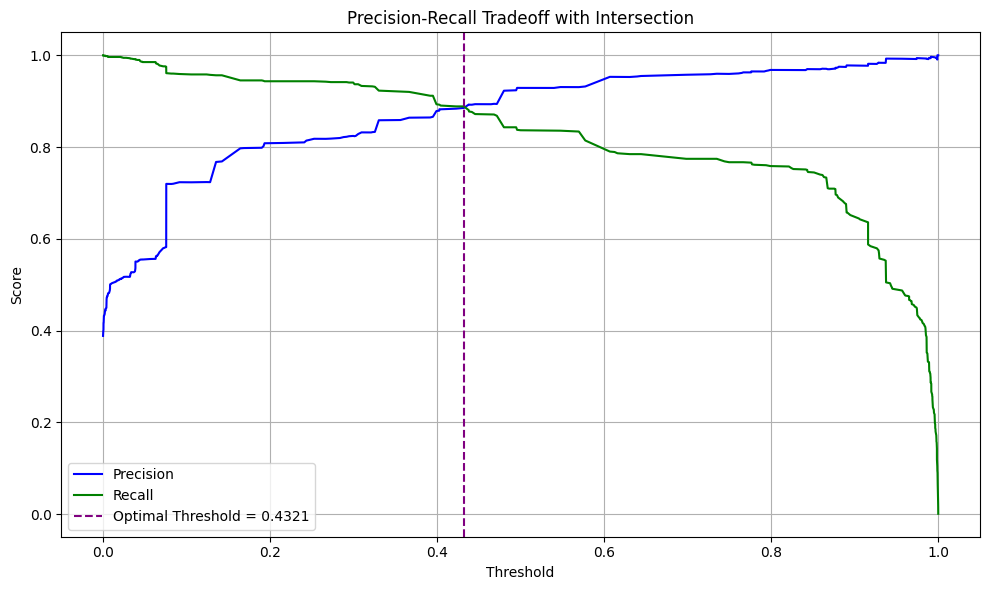

In [ ]:
# Precision-Recall Curve

plt.figure(figsize=(10,6))
plt.plot(thresholds, precision_vals[:-1], label='Precision', color='b')
plt.plot(thresholds, recall_vals[:-1], label='Recall', color='g')
plt.axvline(optimal_threshold, color='purple', linestyle='--',
            label=f'Optimal Threshold = {optimal_threshold:.4f}')
plt.title("Precision-Recall Tradeoff with Intersection")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

* Lower Threshold (≈0.4): A threshold from CV (0.4) might help you capture more leads, favoring recall. This is useful if your goal is to cast a wider net—especially when missing a potential convert is more costly than calling an extra lead.

* Precision-Recall Balance (≈0.4321): Using the intersection approach gives you strong confidence (high precision) with balanced recall, which might mean a slightly narrower set of leads but with higher quality.

* Maximum F1 (≈0.4): A threshold of 0.4 would be more conservative, favoring clear-cut predictions. However, if it’s too high, you risk excluding potential hot leads.

* If you want to cast a wide net (and your cost per call is low): A threshold closer to 0.4 might be preferable.

* If you want high confidence in each lead contacted (minimizing wasted calls): Then a threshold around 0.432 would be more attractive.

In [ ]:
# Lead Scoring and Evaluation at 0.4321 Threshold

# 1. Predict probabilities and generate lead scores for training data
y_train_prob = logm_refined.predict(X_train_refined_sm)
lead_scores_train = (y_train_prob * 100).round(2)
y_train_pred_04 = (y_train_prob >= 0.4321).astype(int)  # Use 0.4321 threshold

# 2. Create DataFrame for training results
train_results = pd.DataFrame({
    'Actual': y_train,
    'Predicted': y_train_pred_04,  # Use predictions at 0.4321 threshold
    'Probability': y_train_prob.round(4),
    'Lead Score': lead_scores_train
})
print("Training Results (Threshold 0.4321):\n", train_results.head())


Training Results (Threshold 0.4321):
    Actual  Predicted  Probability  Lead Score
0       0          0         0.08        7.56
1       1          1         0.99       98.60
2       0          0         0.25       24.67
3       0          0         0.04        4.36
4       0          1         0.47       47.15


In [ ]:

# 3. Predict probabilities and classify for test data
y_test_prob_04 = logm_refined.predict(X_test_refined_sm)
y_test_pred_04 = (y_test_prob_04 >= 0.4321).astype(int)  # Use 0.4321 threshold

# 4. Calculate and print evaluation metrics for test data
conf_matrix_04 = confusion_matrix(y_test, y_test_pred_04)  # Use y_test_pred_04
tn, fp, fn, tp = conf_matrix_04.ravel()

precision_04 = precision_score(y_test, y_test_pred_04)  # Use y_test_pred_04
recall_04 = recall_score(y_test, y_test_pred_04)  # Use y_test_pred_04
f1_04 = f1_score(y_test, y_test_pred_04)  # Use y_test_pred_04
specificity_04 = tn / (tn + fp)
roc_auc_metric_04 = roc_auc_score(y_test, y_test_prob_04)
print("\nTest Set Evaluation Metrics (Threshold 0.4321):")
print("Confusion Matrix:\n", conf_matrix_04)  # Print conf_matrix_04
print(f"Precision: {precision_04:.4f}")
print(f"Recall (Sensitivity): {recall_04:.4f}")
print(f"Specificity: {specificity_04:.4f}")
print(f"F1 Score: {f1_04:.4f}")
print(f"ROC AUC: {roc_auc_metric_04:.4f}")



Test Set Evaluation Metrics (Threshold 0.4321):
Confusion Matrix:
 [[1571  124]
 [ 120  957]]
Precision: 0.8853
Recall (Sensitivity): 0.8886
Specificity: 0.9268
F1 Score: 0.8869
ROC AUC: 0.9647


In [ ]:
y_test_prob = logm_refined.predict(X_test_refined_sm)

# 2. Apply the 0.4321 threshold for classification
y_test_pred_04321 = (y_test_prob >= 0.4321).astype(int)

# 3. Generate lead scores (if needed)
lead_scores_test_04321 = (y_test_prob * 100).round(2)

# 4. Create a DataFrame for deployment results (optional)
test_results_04321 = pd.DataFrame({
    'Actual': y_test,  # Assuming y_test is your ground truth for the test data
    'Predicted': y_test_pred_04321,
    'Probability': y_test_prob.round(4),
    'Lead Score': lead_scores_test_04321
})


# Sort by 'Lead Score' in descending order
test_results_04321_sorted = test_results_04321.sort_values(by=['Lead Score'], ascending=False)

# Display the sorted DataFrame (optional)
print("Sorted Deployment Results (Threshold 0.4321):\n", test_results_04321_sorted.head())

Sorted Deployment Results (Threshold 0.4321):
       Actual  Predicted  Probability  Lead Score
31      0.00       1.00         1.00      100.00
1198     NaN       1.00         1.00      100.00
1315    0.00       1.00         1.00      100.00
2408     NaN       1.00         1.00      100.00
1962    0.00       1.00         1.00      100.00


In [ ]:
# Tier Classification for Test Leads
# Classify lead scores into tiers ('Cold', 'Warm', 'Hot') and display the counts.

test_results_04321['Tier'] = pd.cut(
    test_results_04321['Lead Score'],
    bins=[0, 40, 70, 100],
    labels=['Cold', 'Warm', 'Hot']
)
print(test_results_04321['Tier'].value_counts())

Tier
Cold    1656
Hot      870
Warm     223
Name: count, dtype: int64


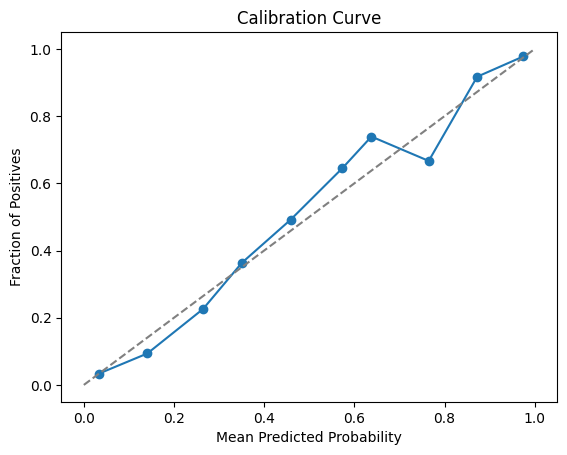

In [ ]:
from sklearn.calibration import calibration_curve
prob_true, prob_pred = calibration_curve(y_test, logm_refined.predict(X_test_refined_sm), n_bins=10)
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("Calibration Curve")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.show()


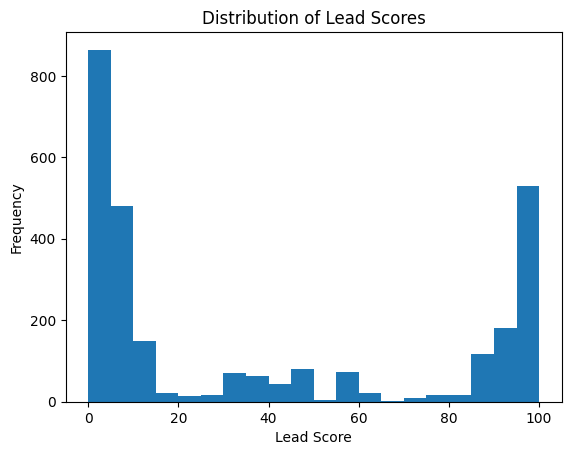

In [ ]:
plt.hist(test_results_04321['Lead Score'], bins=20) # Changed 'Lead_Score' to 'Lead Score'
plt.title('Distribution of Lead Scores')
plt.xlabel('Lead Score')
plt.ylabel('Frequency')
plt.show()

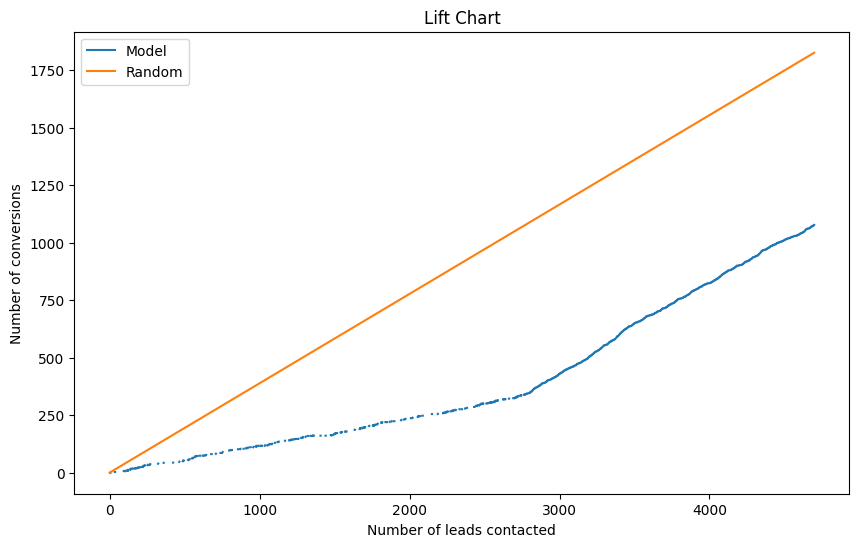

In [ ]:
# Sort by predicted probability (descending)
sorted_df = test_results_04321.sort_values('Probability', ascending=False).reset_index(drop=True)

# Calculate cumulative conversions
sorted_df['cum_conversions'] = sorted_df['Actual'].cumsum()
sorted_df['random_cum_conversions'] = sorted_df['Actual'].mean() * (sorted_df.index + 1)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(sorted_df.index, sorted_df['cum_conversions'], label='Model')
plt.plot(sorted_df.index, sorted_df['random_cum_conversions'], label='Random')
plt.xlabel('Number of leads contacted')
plt.ylabel('Number of conversions')
plt.title('Lift Chart')
plt.legend()
plt.show()

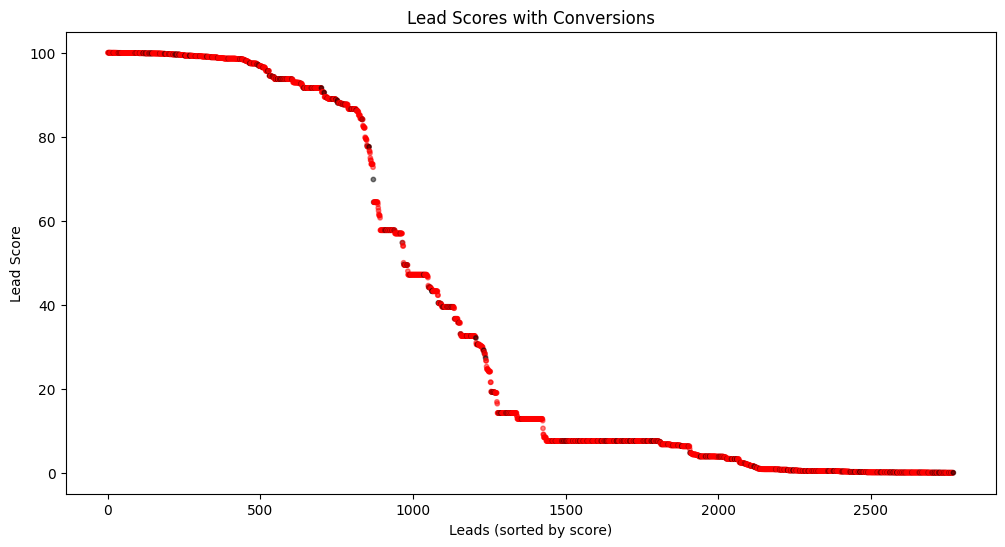

In [ ]:
plt.figure(figsize=(12, 6))
plt.scatter(range(len(test_results_04321_sorted)),
            test_results_04321_sorted['Lead Score'], # Changed 'Lead_Score' to 'Lead Score'
            c=np.where(test_results_04321_sorted['Actual'] == 1, 'black', 'red'),
            alpha=0.5, s=10)
plt.title('Lead Scores with Conversions')
plt.xlabel('Leads (sorted by score)')
plt.ylabel('Lead Score')
plt.show()

Intern capacity configuration:
- 10 interns, each making 3 calls per day
- Daily capacity: 30 calls
- Total capacity over 60 days: 1800 calls
- Total number of leads available: 4699

Threshold metrics:
 Threshold  Number of Leads  Leads (%)  Expected Conversion Rate (%)  Expected Conversions  Daily Calls (60-day period)
        20             1256      26.73                         38.99                   489                           21
        25             1242      26.43                         39.41                   489                           21
        30             1225      26.07                         39.24                   480                           21
        35             1155      24.58                         39.88                   460                           20
        40             1093      23.26                         38.60                   421                           19
        45             1050      22.35                         38.02          

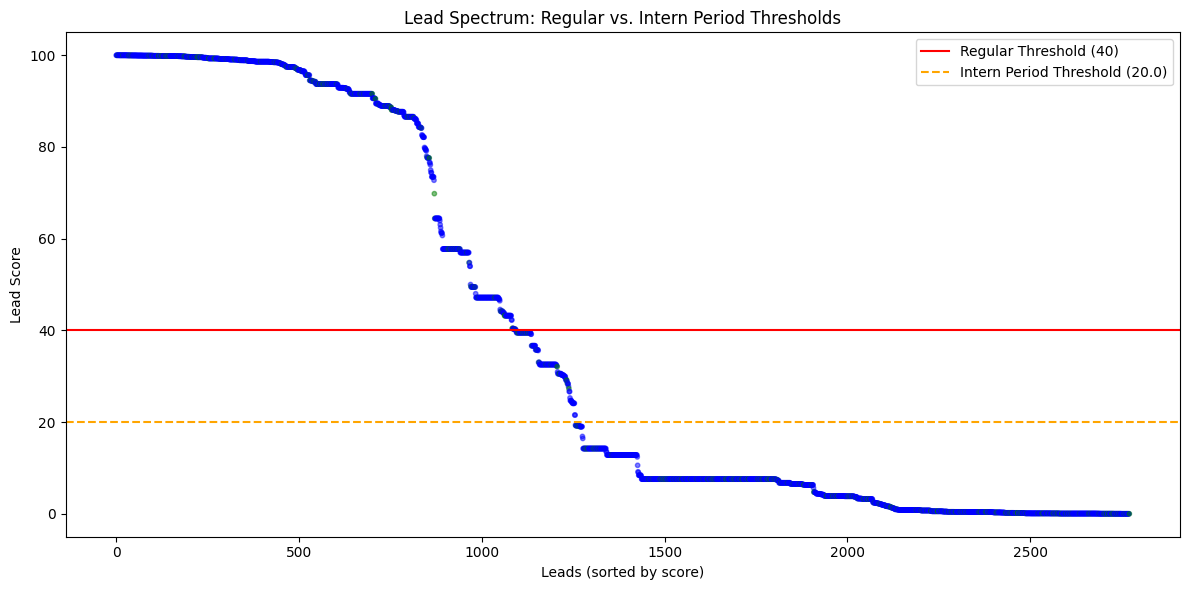

In [ ]:
import math
# For example, here I'll assume test_results_04321_sorted (it was created after sorting test_results_04321).

# Intern capacity configuration
num_interns = 10                # Number of interns
calls_per_intern_per_day = 3    # Number of calls per intern per day
intern_period_days = 60         # Intern period (in days)
intern_daily_capacity = num_interns * calls_per_intern_per_day  # e.g., 30 calls per day
total_intern_capacity = intern_daily_capacity * intern_period_days  # Total calls over period

print(f"Intern capacity configuration:")
print(f"- {num_interns} interns, each making {calls_per_intern_per_day} calls per day")
print(f"- Daily capacity: {intern_daily_capacity} calls")
print(f"- Total capacity over {intern_period_days} days: {total_intern_capacity} calls")
print(f"- Total number of leads available: {len(test_results_04321_sorted)}\n")

# Test a range of lead score thresholds (from 20 to 65, in steps of 5)
threshold_ranges = range(20, 70, 5)
threshold_data = []

for threshold in threshold_ranges:
    # Select leads with a Lead Score >= threshold
    # Changed 'Lead_Score' to 'Lead Score' to match the actual column name
    selected_leads = test_results_04321_sorted[test_results_04321_sorted['Lead Score'] >= threshold]
    leads_count = len(selected_leads)
    leads_percentage = leads_count / len(test_results_04321_sorted) * 100

    # Expected conversion rate (mean of Actual values in selected subset)
    expected_conv_rate = selected_leads['Actual'].mean() * 100 if leads_count > 0 else 0
    # Expected number of conversions
    expected_conversions = int(leads_count * expected_conv_rate / 100)
    # Daily call load across the intern period
    daily_calls = math.ceil(leads_count / intern_period_days)

    threshold_data.append({
        'Threshold': threshold,
        'Number of Leads': leads_count,
        'Leads (%)': round(leads_percentage, 2),
        'Expected Conversion Rate (%)': round(expected_conv_rate, 2),
        'Expected Conversions': expected_conversions,
        'Daily Calls (60-day period)': daily_calls
    })

threshold_df = pd.DataFrame(threshold_data)
print("Threshold metrics:")
print(threshold_df.to_string(index=False))

# ---- Revised Threshold Selection ----
# Only consider thresholds that do NOT exceed intern daily capacity.
candidates = threshold_df[threshold_df['Daily Calls (60-day period)'] <= intern_daily_capacity]

if not candidates.empty:
    # Among candidates, pick the one that offers the highest daily calls (maximize utilization)
    best_candidate = candidates.sort_values('Daily Calls (60-day period)', ascending=False).iloc[0]
    intern_threshold = best_candidate['Threshold']
else:
    # If all thresholds lead to daily calls above capacity, choose the threshold with the minimal daily calls.
    intern_threshold = threshold_df.sort_values('Daily Calls (60-day period)').iloc[0]['Threshold']

print(f"\nRecommended threshold for intern period: {intern_threshold}")

# Calculate intern leads based on the chosen threshold
# Changed 'Lead_Score' to 'Lead Score' to match the actual column name
intern_leads = test_results_04321_sorted[test_results_04321_sorted['Lead Score'] >= intern_threshold]
intern_leads_count = len(intern_leads)
daily_call_volume = math.ceil(intern_leads_count / intern_period_days)
conversion_rate_intern = intern_leads['Actual'].mean()  # proportion

print("\nIntern Period Strategy (Single-touch):")
print(f"  - Total leads targeted: {intern_leads_count} "
      f"({intern_leads_count/len(test_results_04321_sorted):.1%} of total leads)")
print(f"  - Daily call volume (if calling each lead once): ~{daily_call_volume} calls")
print(f"  - Per intern daily call volume: ~{daily_call_volume/num_interns:.1f} calls")
print(f"  - Expected conversion rate at threshold {intern_threshold}: {conversion_rate_intern:.1%}")
print(f"  - Expected total conversions: ~{int(intern_leads_count * conversion_rate_intern)}")

total_calls_used = intern_leads_count
capacity_utilization = (total_calls_used / total_intern_capacity) * 100
print(f"\nStrategy Quality Assessment:")
print(f"  - Capacity utilization: {capacity_utilization:.1f}% of total available call capacity")

# If capacity utilization is low, a multi-touch approach
if capacity_utilization < 75:
    max_reasonable_attempts = min(3, math.floor(total_intern_capacity / intern_leads_count))
    if max_reasonable_attempts > 1:
        adjusted_daily_call_volume = math.ceil((intern_leads_count * max_reasonable_attempts) / intern_period_days)
        new_utilization = (intern_leads_count * max_reasonable_attempts / total_intern_capacity) * 100
        print("\nConsider a strategic multi-touch approach:")
        print(f"  - Contact high-potential leads {max_reasonable_attempts} times over the period")
        print(f"  - This would increase capacity utilization to {new_utilization:.1f}%")
        print(f"  - Adjusted daily call volume: ~{adjusted_daily_call_volume} calls "
              f"({adjusted_daily_call_volume/num_interns:.1f} per intern)")
        print(f"  - Focus follow-ups on leads showing the most interest or highest scores")
    else:
        print("\nDespite lower capacity utilization, multiple touches may not be advisable.")
        print("  - Consider using the extra capacity for quality control or longer calls")
else:
    print("\nThe single-touch strategy effectively utilizes intern capacity.")

# Plotting the lead score spectrum and thresholds for visualization
plt.figure(figsize=(12, 6))
# Color-code based on Actual conversion (green for converted, blue for non-converted)
colors = np.where(test_results_04321_sorted['Actual'] == 1, 'green', 'blue')
# Changed 'Lead_Score' to 'Lead Score' to match the actual column name
plt.scatter(range(len(test_results_04321_sorted)), test_results_04321_sorted['Lead Score'], c=colors, alpha=0.5, s=10)

plt.axhline(y=40, color='red', linestyle='-', label='Regular Threshold (40)')
plt.axhline(y=intern_threshold, color='orange', linestyle='--', label=f'Intern Period Threshold ({intern_threshold})')

plt.title('Lead Spectrum: Regular vs. Intern Period Thresholds')
plt.xlabel('Leads (sorted by score)')
plt.ylabel('Lead Score')
plt.legend()
plt.tight_layout()
plt.show()

# Intern Strategy
* If you choose a lower threshold (like 20), you get more leads but at a lower quality.

* If you choose a higher threshold, you’ll contact fewer leads—but those leads might be “hotter.”
* When designing the intern strategy

* Too low a threshold → Too many leads (most of them may be “cold” or only slightly qualified) even if you’re still under capacity.

* Too high a threshold → You might miss potential converts.

* Among thresholds that do not exceed daily capacity, choose the one that gives the highest daily call volume.This means: from the candidate thresholds (where daily calls ≤ interns’ capacity), pick the one that comes closest to fully utilizing intern capacity without overloading them
* Right now my code had taken dummy data hence I am getting the lowest threshold for max utilisation (69%)
* If the data is such that there is less utilisation we can use the multi touch approach



In [4]:
from google.colab import drive
drive.mount('/content/drive')
!ls /content/drive/MyDrive


Mounted at /content/drive
 200020061_Groww.gslides
 200020061_IITB.gslides
'(2002) Harry Potter and the Chamber of Secrets.mp4'
 20220312_204017.jpg
 20220312_210504.jpg
 20220312_210533.jpg
 20220312_233227.jpg
 20220312_233228.jpg
 20220312_233246.jpg
 20220312_233303.jpg
 20220312_233358.jpg
 20220312_233448.jpg
 20220312_233452.jpg
 20220312_233518.jpg
 20220312_233524.jpg
 20220312_233525.jpg
 20220312_233526.jpg
'20220312_233527(0).jpg'
 20220312_233527.jpg
 20220312_233543.jpg
 20220312_233548.jpg
 20220312_233549.jpg
 20220312_234834.jpg
 20220312_234856.jpg
 20220312_234858.jpg
 20220312_234909.jpg
 20220312_234912.jpg
 20220312_234913.jpg
 20220312_234917.jpg
 20220312_234921.jpg
 20220312_235020.jpg
 20220312_235026.jpg
 20220312_235030.jpg
 20220312_235032.jpg
 20220312_235035.jpg
 20220312_235043.jpg
 20220312_235044.jpg
 20220312_235046.jpg
 20220312_235049.jpg
 20220312_235103.jpg
 20220312_235104.jpg
 20220312_235106.jpg
 20220312_235149.jpg
 20220312_235153.jpg
 202203

In [6]:
!jupyter nbconvert --to markdown "/content/drive/MyDrive/Colab Notebooks/Optimising Code&Conquer_Level2_JasBilling.ipynb"


[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/Optimising Code&Conquer_Level2_JasBilling.ipynb to markdown
[NbConvertApp] Support files will be in Optimising Code&Conquer_Level2_JasBilling_files/
[NbConvertApp] Making directory /content/drive/MyDrive/Colab Notebooks/Optimising Code&Conquer_Level2_JasBilling_files
[NbConvertApp] Writing 144391 bytes to /content/drive/MyDrive/Colab Notebooks/Optimising Code&Conquer_Level2_JasBilling.md


In [9]:
from google.colab import files
files.download("/content/drive/MyDrive/Colab Notebooks/Optimising Code&Conquer_Level2_JasBilling.md")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>